<a href="https://colab.research.google.com/github/ShreyPandit/Quantile-Regression_Lipschitz/blob/master/California_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

In [2]:
dataset = pd.read_csv("housing.csv")

In [3]:
dataset = dataset.dropna(axis=0)

In [4]:
dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
dataset = dataset.drop('ocean_proximity',axis=1)

In [6]:
dataset = shuffle(dataset)

In [7]:
x_test = dataset.iloc[:2000,:]

In [8]:
x_train = dataset.iloc[2000:,:]

In [9]:
y_train = x_train.pop("median_house_value")

In [10]:
y_test = x_test.pop("median_house_value")

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
x_train = scaler.transform(x_train)

In [14]:
x_test = scaler.transform(x_test)

In [15]:
y_train = np.expand_dims(y_train,axis=1)

In [16]:
y_test = np.expand_dims(y_test,axis=1)

In [17]:
scaler.fit(y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [61]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(20 ,activation='relu'))
model.add(layers.Dense(15 ,activation='relu'))
model.add(layers.Dense(1,activation=keras.activations.softsign))

In [62]:
from tensorflow.keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [63]:
lrs = []
K1 = 0.
batch_size=16
from tqdm import tqdm

In [64]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
    
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      
      if activ > Kz:
          Kz = activ
    print("The value of K_z is ",Kz)
    K1 = (1/batch_size)*(Kz)*max(q,1-q)
    lr = 1 / K1
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [65]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [66]:
import tensorflow.keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [36]:
q = 0.95
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [37]:
history_const=model.fit(x_train, y_train, epochs = 1000, batch_size = 16,validation_data=(x_test,y_test))

Epoch 1/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.2405 - val_loss: 0.2170
Epoch 2/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.2053 - val_loss: 0.2065
Epoch 3/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1987 - val_loss: 0.2022
Epoch 4/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1955 - val_loss: 0.1998
Epoch 5/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1936 - val_loss: 0.1982
Epoch 6/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1922 - val_loss: 0.1971
Epoch 7/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1913 - val_loss: 0.1963
Epoch 8/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1905 - val_loss: 0.1956
Epoch 9/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1899 - val_loss: 0.1951
Epoch 10/1000
1153/1153 [==============================] - 2s 2m

In [26]:
history=model.fit(x_train, y_train, epochs = 1000, batch_size = 16,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

100%|██████████| 1153/1153 [00:02<00:00, 407.19it/s]


The value of K_z is  12.254592
Epoch 0 LR = 1.374350557170656
Epoch 1/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1834 - val_loss: 0.1837


100%|██████████| 1153/1153 [00:01<00:00, 802.99it/s]

The value of K_z is  178.7372
Epoch 1 LR = 0.0942283165636535
Epoch 2/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1782

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1741 - val_loss: 0.1780


100%|██████████| 1153/1153 [00:01<00:00, 686.58it/s]

The value of K_z is  170.67278
Epoch 2 LR = 0.09868067848932988
Epoch 3/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2035

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1715 - val_loss: 0.1764


100%|██████████| 1153/1153 [00:01<00:00, 684.80it/s]

The value of K_z is  171.891
Epoch 3 LR = 0.09798130576496523
Epoch 4/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0453

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1707 - val_loss: 0.1756


100%|██████████| 1153/1153 [00:01<00:00, 670.50it/s]

The value of K_z is  178.44302
Epoch 4 LR = 0.09438365768339488
Epoch 5/1000
  55/1153 [>.............................] - ETA: 2s - loss: 0.1655

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1699 - val_loss: 0.1748


100%|██████████| 1153/1153 [00:01<00:00, 820.87it/s]


The value of K_z is  181.53491
Epoch 5 LR = 0.09277612260616022
Epoch 6/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1694 - val_loss: 0.1746


100%|██████████| 1153/1153 [00:01<00:00, 810.73it/s]

The value of K_z is  184.83316
Epoch 6 LR = 0.09112058261988308
Epoch 7/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1497

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1689 - val_loss: 0.1746


100%|██████████| 1153/1153 [00:01<00:00, 817.24it/s]


The value of K_z is  188.77783
Epoch 7 LR = 0.08921654138061019
Epoch 8/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1686 - val_loss: 0.1738


100%|██████████| 1153/1153 [00:01<00:00, 786.86it/s]

The value of K_z is  192.3796
Epoch 8 LR = 0.08754621532183922
Epoch 9/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1598

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1683 - val_loss: 0.1740


100%|██████████| 1153/1153 [00:01<00:00, 806.50it/s]

The value of K_z is  192.87666
Epoch 9 LR = 0.08732059640099916
Epoch 10/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1663

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1679 - val_loss: 0.1736


100%|██████████| 1153/1153 [00:01<00:00, 807.93it/s]

The value of K_z is  194.0834
Epoch 10 LR = 0.08677766810092542
Epoch 11/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1979

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1675 - val_loss: 0.1731


100%|██████████| 1153/1153 [00:01<00:00, 823.10it/s]

The value of K_z is  195.35373
Epoch 11 LR = 0.08621337984171747
Epoch 12/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3205

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1673 - val_loss: 0.1735


100%|██████████| 1153/1153 [00:01<00:00, 804.97it/s]

The value of K_z is  197.08379
Epoch 12 LR = 0.08545657460751188
Epoch 13/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1470

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1672 - val_loss: 0.1733


100%|██████████| 1153/1153 [00:01<00:00, 823.85it/s]

The value of K_z is  198.63855
Epoch 13 LR = 0.08478769745207057
Epoch 14/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0835

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1670 - val_loss: 0.1729


100%|██████████| 1153/1153 [00:01<00:00, 821.95it/s]

The value of K_z is  202.91885
Epoch 14 LR = 0.08299921348411103
Epoch 15/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1266

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1667 - val_loss: 0.1722


100%|██████████| 1153/1153 [00:01<00:00, 796.73it/s]

The value of K_z is  202.37202
Epoch 15 LR = 0.08322348556705177
Epoch 16/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1427

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1666 - val_loss: 0.1720


100%|██████████| 1153/1153 [00:01<00:00, 797.12it/s]

The value of K_z is  205.35753
Epoch 16 LR = 0.08201357588826086
Epoch 17/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1539

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1664 - val_loss: 0.1717


100%|██████████| 1153/1153 [00:01<00:00, 813.00it/s]

The value of K_z is  207.1043
Epoch 17 LR = 0.0813218545702011
Epoch 18/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1838

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1662 - val_loss: 0.1728


100%|██████████| 1153/1153 [00:01<00:00, 808.98it/s]

The value of K_z is  212.28474
Epoch 18 LR = 0.07933733213686024
Epoch 19/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1535

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1660 - val_loss: 0.1722


100%|██████████| 1153/1153 [00:01<00:00, 804.76it/s]

The value of K_z is  214.58696
Epoch 19 LR = 0.07848615440474384
Epoch 20/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1478

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1659 - val_loss: 0.1717


100%|██████████| 1153/1153 [00:01<00:00, 802.12it/s]

The value of K_z is  212.24643
Epoch 20 LR = 0.07935165414715456
Epoch 21/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1780

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1657 - val_loss: 0.1715


100%|██████████| 1153/1153 [00:01<00:00, 808.83it/s]

The value of K_z is  216.00739
Epoch 21 LR = 0.07797004367864929
Epoch 22/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1707

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1655 - val_loss: 0.1715


100%|██████████| 1153/1153 [00:01<00:00, 814.52it/s]

The value of K_z is  216.79683
Epoch 22 LR = 0.07768612356311139
Epoch 23/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1529

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1654 - val_loss: 0.1719


100%|██████████| 1153/1153 [00:01<00:00, 802.39it/s]

The value of K_z is  219.3064
Epoch 23 LR = 0.07679714560609203
Epoch 24/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1605

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1653 - val_loss: 0.1715


100%|██████████| 1153/1153 [00:01<00:00, 811.70it/s]

The value of K_z is  219.92249
Epoch 24 LR = 0.07658200677495315
Epoch 25/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1619

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1652 - val_loss: 0.1731


100%|██████████| 1153/1153 [00:01<00:00, 777.98it/s]

The value of K_z is  223.2058
Epoch 25 LR = 0.07545550168811803
Epoch 26/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1990

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1652 - val_loss: 0.1714


100%|██████████| 1153/1153 [00:01<00:00, 801.22it/s]

The value of K_z is  223.89787
Epoch 26 LR = 0.07522226559434202
Epoch 27/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1712

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1651 - val_loss: 0.1714


100%|██████████| 1153/1153 [00:01<00:00, 800.80it/s]

The value of K_z is  223.74965
Epoch 27 LR = 0.07527209689413193
Epoch 28/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1647

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1649 - val_loss: 0.1714


100%|██████████| 1153/1153 [00:01<00:00, 805.80it/s]

The value of K_z is  224.14075
Epoch 28 LR = 0.0751407563475041
Epoch 29/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1833

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1649 - val_loss: 0.1714


100%|██████████| 1153/1153 [00:01<00:00, 805.87it/s]

The value of K_z is  226.74141
Epoch 29 LR = 0.07427891233022925
Epoch 30/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1651

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1646 - val_loss: 0.1707


100%|██████████| 1153/1153 [00:01<00:00, 825.16it/s]

The value of K_z is  230.29901
Epoch 30 LR = 0.07313147014037058
Epoch 31/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1294

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1647 - val_loss: 0.1709


100%|██████████| 1153/1153 [00:01<00:00, 822.03it/s]

The value of K_z is  231.66273
Epoch 31 LR = 0.07270096877783495
Epoch 32/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1605

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1647 - val_loss: 0.1706


100%|██████████| 1153/1153 [00:01<00:00, 805.49it/s]

The value of K_z is  230.868
Epoch 32 LR = 0.0729512342083722
Epoch 33/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1413

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1643 - val_loss: 0.1710


100%|██████████| 1153/1153 [00:01<00:00, 814.66it/s]

The value of K_z is  229.7817
Epoch 33 LR = 0.07329611458406332
Epoch 34/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1757

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1643 - val_loss: 0.1714


100%|██████████| 1153/1153 [00:01<00:00, 814.14it/s]


The value of K_z is  231.7006
Epoch 34 LR = 0.07268908553772312
Epoch 35/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1641 - val_loss: 0.1708


100%|██████████| 1153/1153 [00:01<00:00, 806.08it/s]

The value of K_z is  230.66356
Epoch 35 LR = 0.07301589093265219
Epoch 36/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1657

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1641 - val_loss: 0.1717


100%|██████████| 1153/1153 [00:01<00:00, 821.97it/s]


The value of K_z is  235.48856
Epoch 36 LR = 0.07151984604178895
Epoch 37/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1641 - val_loss: 0.1710


100%|██████████| 1153/1153 [00:01<00:00, 805.70it/s]

The value of K_z is  236.96542
Epoch 37 LR = 0.07107410443443359
Epoch 38/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1376

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1641 - val_loss: 0.1710


100%|██████████| 1153/1153 [00:01<00:00, 818.63it/s]

The value of K_z is  238.27956
Epoch 38 LR = 0.07068212450321054
Epoch 39/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1596

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1641 - val_loss: 0.1704


100%|██████████| 1153/1153 [00:01<00:00, 810.97it/s]

The value of K_z is  240.13492
Epoch 39 LR = 0.07013601099123201
Epoch 40/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1802

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1639 - val_loss: 0.1709


100%|██████████| 1153/1153 [00:01<00:00, 810.94it/s]

The value of K_z is  245.59839
Epoch 40 LR = 0.06857579707356846
Epoch 41/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1473

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1638 - val_loss: 0.1703


100%|██████████| 1153/1153 [00:01<00:00, 841.53it/s]

The value of K_z is  245.60495
Epoch 41 LR = 0.06857396508704826
Epoch 42/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1327

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1636 - val_loss: 0.1703


100%|██████████| 1153/1153 [00:01<00:00, 816.76it/s]

The value of K_z is  246.72737
Epoch 42 LR = 0.06826200587378514
Epoch 43/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1959

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1636 - val_loss: 0.1701


100%|██████████| 1153/1153 [00:01<00:00, 829.41it/s]

The value of K_z is  248.2583
Epoch 43 LR = 0.06784105590893465
Epoch 44/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1564

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1636 - val_loss: 0.1703


100%|██████████| 1153/1153 [00:01<00:00, 803.83it/s]

The value of K_z is  250.41101
Epoch 44 LR = 0.06725784626338899
Epoch 45/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1559

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1635 - val_loss: 0.1703


100%|██████████| 1153/1153 [00:01<00:00, 830.76it/s]

The value of K_z is  254.37732
Epoch 45 LR = 0.0662091467396736
Epoch 46/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1598

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1634 - val_loss: 0.1701


100%|██████████| 1153/1153 [00:01<00:00, 820.78it/s]

The value of K_z is  253.34001
Epoch 46 LR = 0.06648024193655887
Epoch 47/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1613

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1633 - val_loss: 0.1699


100%|██████████| 1153/1153 [00:01<00:00, 737.31it/s]

The value of K_z is  255.69196
Epoch 47 LR = 0.06586873343687889
Epoch 48/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1506

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1633 - val_loss: 0.1701


100%|██████████| 1153/1153 [00:01<00:00, 808.34it/s]

The value of K_z is  259.10226
Epoch 48 LR = 0.06500176793853829
Epoch 49/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1408

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1631 - val_loss: 0.1702


100%|██████████| 1153/1153 [00:01<00:00, 794.33it/s]

The value of K_z is  260.86353
Epoch 49 LR = 0.06456289831220373
Epoch 50/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1606

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1630 - val_loss: 0.1698


100%|██████████| 1153/1153 [00:01<00:00, 838.99it/s]

The value of K_z is  263.88577
Epoch 50 LR = 0.06382346835341075
Epoch 51/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1565

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1631 - val_loss: 0.1698


100%|██████████| 1153/1153 [00:01<00:00, 832.98it/s]

The value of K_z is  262.93042
Epoch 51 LR = 0.06405536973683844
Epoch 52/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1455

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1631 - val_loss: 0.1699


100%|██████████| 1153/1153 [00:01<00:00, 817.72it/s]

The value of K_z is  266.57092
Epoch 52 LR = 0.0631805790481367
Epoch 53/1000
  61/1153 [>.............................] - ETA: 1s - loss: 0.1587

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1628 - val_loss: 0.1707


100%|██████████| 1153/1153 [00:01<00:00, 827.02it/s]

The value of K_z is  270.5934
Epoch 53 LR = 0.06224137163985877
Epoch 54/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1474

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1629 - val_loss: 0.1701


100%|██████████| 1153/1153 [00:01<00:00, 805.96it/s]

The value of K_z is  267.82864
Epoch 54 LR = 0.06288388360659573
Epoch 55/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1425

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1628 - val_loss: 0.1695


100%|██████████| 1153/1153 [00:01<00:00, 837.18it/s]

The value of K_z is  273.4257
Epoch 55 LR = 0.06159664544251609
Epoch 56/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1553

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1628 - val_loss: 0.1702


100%|██████████| 1153/1153 [00:01<00:00, 831.53it/s]

The value of K_z is  272.0152
Epoch 56 LR = 0.061916045140959546
Epoch 57/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0403

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1626 - val_loss: 0.1696


100%|██████████| 1153/1153 [00:01<00:00, 834.94it/s]

The value of K_z is  274.0078
Epoch 57 LR = 0.06146578489676419
Epoch 58/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0949

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1625 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 824.70it/s]

The value of K_z is  273.80276
Epoch 58 LR = 0.0615118158860288
Epoch 59/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1752

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1626 - val_loss: 0.1706


100%|██████████| 1153/1153 [00:01<00:00, 841.73it/s]

The value of K_z is  277.63754
Epoch 59 LR = 0.06066220403003529
Epoch 60/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2188

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1625 - val_loss: 0.1698


100%|██████████| 1153/1153 [00:01<00:00, 839.36it/s]

The value of K_z is  281.2879
Epoch 60 LR = 0.0598749718476696
Epoch 61/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0427

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1625 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 830.33it/s]

The value of K_z is  281.13287
Epoch 61 LR = 0.059907989597138854
Epoch 62/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1130

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1623 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 834.34it/s]

The value of K_z is  282.6074
Epoch 62 LR = 0.05959541674498241
Epoch 63/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2233

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1624 - val_loss: 0.1696


100%|██████████| 1153/1153 [00:01<00:00, 830.53it/s]

The value of K_z is  286.67212
Epoch 63 LR = 0.058750412539756325
Epoch 64/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0625

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1626 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 839.75it/s]

The value of K_z is  294.36832
Epoch 64 LR = 0.05721439540370299
Epoch 65/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1417

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1624 - val_loss: 0.1697


100%|██████████| 1153/1153 [00:01<00:00, 826.68it/s]

The value of K_z is  292.9072
Epoch 65 LR = 0.057499800245859774
Epoch 66/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0479

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1623 - val_loss: 0.1702


100%|██████████| 1153/1153 [00:01<00:00, 824.80it/s]

The value of K_z is  302.33945
Epoch 66 LR = 0.055705947169907635
Epoch 67/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0485

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1621 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 819.85it/s]

The value of K_z is  293.1174
Epoch 67 LR = 0.057458565061743974
Epoch 68/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1274

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1623 - val_loss: 0.1698


100%|██████████| 1153/1153 [00:01<00:00, 845.98it/s]

The value of K_z is  295.01324
Epoch 68 LR = 0.05708931910614178
Epoch 69/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2911

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1620 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 850.28it/s]

The value of K_z is  297.19904
Epoch 69 LR = 0.05666944788913149
Epoch 70/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0512

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1621 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 806.94it/s]

The value of K_z is  310.59216
Epoch 70 LR = 0.054225789523536266
Epoch 71/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1676

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1620 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 816.45it/s]


The value of K_z is  302.55743
Epoch 71 LR = 0.05566581206063361
Epoch 72/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1620 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 817.69it/s]

The value of K_z is  300.81073
Epoch 72 LR = 0.05598904422143263
Epoch 73/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3025

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1624 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 837.83it/s]

The value of K_z is  297.5619
Epoch 73 LR = 0.05660034382446103
Epoch 74/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3103

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1620 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 832.28it/s]

The value of K_z is  301.28525
Epoch 74 LR = 0.055900862674116765
Epoch 75/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1103

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1618 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 825.97it/s]

The value of K_z is  303.4924
Epoch 75 LR = 0.055494322760092744
Epoch 76/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1677

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1617 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 839.07it/s]

The value of K_z is  304.84622
Epoch 76 LR = 0.0552478727040489
Epoch 77/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2623

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1617 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 830.52it/s]

The value of K_z is  305.58136
Epoch 77 LR = 0.055114962740833225
Epoch 78/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0529

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1617 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 810.62it/s]

The value of K_z is  304.84045
Epoch 78 LR = 0.055248918037455345
Epoch 79/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1471

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1617 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 822.95it/s]

The value of K_z is  310.7595
Epoch 79 LR = 0.05419659174611465
Epoch 80/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0392

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1618 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 812.11it/s]

The value of K_z is  306.7204
Epoch 80 LR = 0.05491028759667399
Epoch 81/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1392

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1617 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 820.16it/s]


The value of K_z is  310.81876
Epoch 81 LR = 0.0541862578510184
Epoch 82/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1617 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 824.70it/s]

The value of K_z is  314.08334
Epoch 82 LR = 0.05362304500188721
Epoch 83/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0853

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1616 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 803.97it/s]

The value of K_z is  316.232
Epoch 83 LR = 0.053258701046116054
Epoch 84/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1602

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1615 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 813.42it/s]

The value of K_z is  318.6305
Epoch 84 LR = 0.05285779492073257
Epoch 85/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1441

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1617 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 835.07it/s]

The value of K_z is  317.54205
Epoch 85 LR = 0.05303897575842793
Epoch 86/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2052

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1614 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 805.12it/s]

The value of K_z is  320.5083
Epoch 86 LR = 0.05254810943150204
Epoch 87/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1591

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1614 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 817.64it/s]

The value of K_z is  320.65933
Epoch 87 LR = 0.05252335911650142
Epoch 88/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1527

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1613 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 824.65it/s]

The value of K_z is  320.78027
Epoch 88 LR = 0.05250355666412064
Epoch 89/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2719

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1611 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 793.28it/s]

The value of K_z is  322.1907
Epoch 89 LR = 0.0522737156472606
Epoch 90/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1484

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1615 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 705.48it/s]

The value of K_z is  317.8224
Epoch 90 LR = 0.05299219285742688
Epoch 91/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1738

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1615 - val_loss: 0.1704


100%|██████████| 1153/1153 [00:01<00:00, 704.26it/s]

The value of K_z is  326.84772
Epoch 91 LR = 0.0515289058863584
Epoch 92/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1577

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1612 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 824.05it/s]

The value of K_z is  323.71298
Epoch 92 LR = 0.05202789566811611
Epoch 93/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0240

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1611 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 795.65it/s]

The value of K_z is  326.14728
Epoch 93 LR = 0.05163957024296162
Epoch 94/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1601

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1611 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 799.74it/s]

The value of K_z is  325.89386
Epoch 94 LR = 0.05167972563282868
Epoch 95/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1481

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1612 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 799.12it/s]

The value of K_z is  326.9761
Epoch 95 LR = 0.05150867301676153
Epoch 96/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1588

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1612 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 819.37it/s]

The value of K_z is  324.64185
Epoch 96 LR = 0.05187903372924846
Epoch 97/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1477

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1609 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 832.87it/s]

The value of K_z is  325.65665
Epoch 97 LR = 0.051717369911993084
Epoch 98/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.4486

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1611 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 840.63it/s]

The value of K_z is  329.49734
Epoch 98 LR = 0.0511145401328056
Epoch 99/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1210

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1609 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 823.93it/s]

The value of K_z is  327.8612
Epoch 99 LR = 0.051369619070908375
Epoch 100/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1092

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1609 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 822.50it/s]

The value of K_z is  326.93103
Epoch 100 LR = 0.05151577459341058
Epoch 101/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1427

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1608 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 832.94it/s]

The value of K_z is  333.57767
Epoch 101 LR = 0.050489307041127106
Epoch 102/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2307

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1609 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 829.90it/s]

The value of K_z is  335.8686
Epoch 102 LR = 0.05014492482770883
Epoch 103/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1970

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1607 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 823.17it/s]

The value of K_z is  338.1709
Epoch 103 LR = 0.04980353229972158
Epoch 104/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0810

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1609 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 827.67it/s]

The value of K_z is  336.67902
Epoch 104 LR = 0.05002422027243625
Epoch 105/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2152

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1608 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 819.68it/s]


The value of K_z is  338.7585
Epoch 105 LR = 0.049717142291683954
Epoch 106/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1607 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 822.05it/s]


The value of K_z is  337.5878
Epoch 106 LR = 0.04988955557470427
Epoch 107/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1608 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 802.76it/s]

The value of K_z is  339.17023
Epoch 107 LR = 0.04965679154566907
Epoch 108/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1498

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1606 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 824.80it/s]

The value of K_z is  339.93134
Epoch 108 LR = 0.04954560967702809
Epoch 109/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0377

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1612 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 828.48it/s]

The value of K_z is  340.8499
Epoch 109 LR = 0.04941208591867987
Epoch 110/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0624

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1605 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 807.25it/s]

The value of K_z is  342.33594
Epoch 110 LR = 0.04919759633228076
Epoch 111/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1526

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1606 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 829.35it/s]

The value of K_z is  343.8792
Epoch 111 LR = 0.04897680552810298
Epoch 112/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0532

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1605 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 822.49it/s]

The value of K_z is  345.0354
Epoch 112 LR = 0.04881268775346077
Epoch 113/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1462

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1605 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 768.39it/s]

The value of K_z is  343.4646
Epoch 113 LR = 0.049035927668564835
Epoch 114/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0662

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1605 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 823.12it/s]

The value of K_z is  351.90054
Epoch 114 LR = 0.04786041280126374
Epoch 115/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1935

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1605 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 810.07it/s]

The value of K_z is  352.30142
Epoch 115 LR = 0.04780595310075775
Epoch 116/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1482

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1604 - val_loss: 0.1696


100%|██████████| 1153/1153 [00:01<00:00, 793.73it/s]

The value of K_z is  350.2861
Epoch 116 LR = 0.04808099765539015
Epoch 117/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1653

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1603 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 799.58it/s]

The value of K_z is  350.14224
Epoch 117 LR = 0.048100752271974245
Epoch 118/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1742

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1603 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 793.15it/s]

The value of K_z is  350.70694
Epoch 118 LR = 0.04802330195603258
Epoch 119/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1601

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1604 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 811.84it/s]

The value of K_z is  352.72098
Epoch 119 LR = 0.04774908872448678
Epoch 120/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1257

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1604 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 812.09it/s]


The value of K_z is  352.74573
Epoch 120 LR = 0.04774573849740767
Epoch 121/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1604 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 815.93it/s]

The value of K_z is  356.47574
Epoch 121 LR = 0.04724614733341322
Epoch 122/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.2006

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1603 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 812.03it/s]


The value of K_z is  355.25867
Epoch 122 LR = 0.04740800669481843
Epoch 123/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1602 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 817.49it/s]

The value of K_z is  356.9512
Epoch 123 LR = 0.04718321482115305
Epoch 124/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1647

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1605 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 830.25it/s]

The value of K_z is  356.13757
Epoch 124 LR = 0.04729100922947157
Epoch 125/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1157

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1603 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 832.01it/s]

The value of K_z is  359.44412
Epoch 125 LR = 0.04685597626332553
Epoch 126/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0394

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1603 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 832.83it/s]

The value of K_z is  360.99072
Epoch 126 LR = 0.04665523019325799
Epoch 127/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0916

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1601 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 818.48it/s]

The value of K_z is  360.59213
Epoch 127 LR = 0.04670680179070476
Epoch 128/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1421

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1601 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 823.41it/s]

The value of K_z is  361.86475
Epoch 128 LR = 0.046542542330980576
Epoch 129/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1208

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1603 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 831.54it/s]

The value of K_z is  360.4504
Epoch 129 LR = 0.04672516619663339
Epoch 130/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0382

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1601 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 838.57it/s]

The value of K_z is  369.25745
Epoch 130 LR = 0.04561073969507318
Epoch 131/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1175

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1601 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 824.84it/s]

The value of K_z is  367.74307
Epoch 131 LR = 0.04579856568939349
Epoch 132/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3527

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1601 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 829.36it/s]

The value of K_z is  369.66864
Epoch 132 LR = 0.045560005460373885
Epoch 133/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2361

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1606 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 756.16it/s]

The value of K_z is  388.4306
Epoch 133 LR = 0.04335936749549131
Epoch 134/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1579

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1604 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 771.71it/s]

The value of K_z is  383.5973
Epoch 134 LR = 0.043905694071620864
Epoch 135/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1125

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1601 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 818.51it/s]

The value of K_z is  382.64792
Epoch 135 LR = 0.044014626605902704
Epoch 136/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1307

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 819.00it/s]

The value of K_z is  379.9517
Epoch 136 LR = 0.044326964918327216
Epoch 137/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1543

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1600 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 825.72it/s]

The value of K_z is  376.87024
Epoch 137 LR = 0.044689401042453794
Epoch 138/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0616

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 821.54it/s]

The value of K_z is  382.8879
Epoch 138 LR = 0.0439870386870665
Epoch 139/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0774

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1600 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 802.07it/s]

The value of K_z is  380.649
Epoch 139 LR = 0.04424576406735884
Epoch 140/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1672

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1600 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 817.55it/s]

The value of K_z is  379.07773
Epoch 140 LR = 0.04442916058391084
Epoch 141/1000
  23/1153 [..............................] - ETA: 2s - loss: 0.1183

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 814.93it/s]

The value of K_z is  378.29724
Epoch 141 LR = 0.04452082497151171
Epoch 142/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1764

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 814.04it/s]

The value of K_z is  377.1941
Epoch 142 LR = 0.04465103147009958
Epoch 143/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2871

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1600 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 840.33it/s]

The value of K_z is  379.84375
Epoch 143 LR = 0.044339561367425145
Epoch 144/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0258

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1598 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 823.46it/s]

The value of K_z is  379.6764
Epoch 144 LR = 0.04435910590098588
Epoch 145/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0974

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 824.22it/s]

The value of K_z is  383.14462
Epoch 145 LR = 0.043957566570963495
Epoch 146/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0606

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1601 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 822.84it/s]

The value of K_z is  378.8934
Epoch 146 LR = 0.0444507747293266
Epoch 147/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3023

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 835.49it/s]

The value of K_z is  380.91068
Epoch 147 LR = 0.044215366925589424
Epoch 148/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1731

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1598 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 827.70it/s]

The value of K_z is  379.89062
Epoch 148 LR = 0.044334090274425426
Epoch 149/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3730

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1598 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 834.79it/s]

The value of K_z is  380.57697
Epoch 149 LR = 0.04425413726357332
Epoch 150/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0788

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 810.75it/s]

The value of K_z is  384.96515
Epoch 150 LR = 0.043749688277379475
Epoch 151/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1675

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1598 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 813.47it/s]

The value of K_z is  381.24542
Epoch 151 LR = 0.04417654422905932
Epoch 152/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1810

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1597 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 811.66it/s]

The value of K_z is  381.6296
Epoch 152 LR = 0.044132071787125214
Epoch 153/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1509

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1597 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 843.17it/s]

The value of K_z is  382.0941
Epoch 153 LR = 0.04407842438229764
Epoch 154/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0505

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1599 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 819.46it/s]

The value of K_z is  379.77267
Epoch 154 LR = 0.04434785963115093
Epoch 155/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1193

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1598 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 835.22it/s]

The value of K_z is  386.55743
Epoch 155 LR = 0.043569477076940234
Epoch 156/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1349

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1596 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 823.44it/s]

The value of K_z is  382.8766
Epoch 156 LR = 0.0439883394252523
Epoch 157/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0397

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1596 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 816.47it/s]

The value of K_z is  391.00992
Epoch 157 LR = 0.04307334540293677
Epoch 158/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1461

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1597 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 809.40it/s]

The value of K_z is  387.15518
Epoch 158 LR = 0.043502208032361676
Epoch 159/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1476

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1595 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 837.28it/s]

The value of K_z is  388.0214
Epoch 159 LR = 0.043405094602277434
Epoch 160/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1164

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1595 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 842.24it/s]

The value of K_z is  390.04767
Epoch 160 LR = 0.04317960758433112
Epoch 161/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2214

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1596 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 817.93it/s]


The value of K_z is  394.47134
Epoch 161 LR = 0.04269538337722211
Epoch 162/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1595 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 811.26it/s]

The value of K_z is  393.6542
Epoch 162 LR = 0.04278400950745612
Epoch 163/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1617

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 817.91it/s]


The value of K_z is  393.74896
Epoch 163 LR = 0.0427737133842861
Epoch 164/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 837.44it/s]

The value of K_z is  393.90506
Epoch 164 LR = 0.04275676293950446
Epoch 165/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1233

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1593 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 826.90it/s]

The value of K_z is  391.3296
Epoch 165 LR = 0.04303815939367787
Epoch 166/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3000

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1597 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 832.76it/s]

The value of K_z is  408.96866
Epoch 166 LR = 0.041181897231691154
Epoch 167/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2417

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1595 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 850.75it/s]

The value of K_z is  402.8737
Epoch 167 LR = 0.041804927389187244
Epoch 168/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1267

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 832.71it/s]

The value of K_z is  400.07007
Epoch 168 LR = 0.04209788883288556
Epoch 169/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2793

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1593 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 826.32it/s]

The value of K_z is  401.3577
Epoch 169 LR = 0.041962831181847286
Epoch 170/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1278

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1595 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 828.59it/s]

The value of K_z is  398.34106
Epoch 170 LR = 0.04228061519662831
Epoch 171/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1831

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1596 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 824.91it/s]

The value of K_z is  401.63913
Epoch 171 LR = 0.041933427348848265
Epoch 172/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0782

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 822.26it/s]

The value of K_z is  401.19144
Epoch 172 LR = 0.04198022121024238
Epoch 173/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0528

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 843.71it/s]

The value of K_z is  401.03833
Epoch 173 LR = 0.04199624823860836
Epoch 174/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3470

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1596 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 841.22it/s]

The value of K_z is  399.588
Epoch 174 LR = 0.04214867495537227
Epoch 175/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2089

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1600 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 843.40it/s]

The value of K_z is  400.6991
Epoch 175 LR = 0.04203180242410481
Epoch 176/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1778

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1595 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 823.29it/s]


The value of K_z is  406.409
Epoch 176 LR = 0.041441270751392964
Epoch 177/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 755.84it/s]

The value of K_z is  405.38583
Epoch 177 LR = 0.0415458653494786
Epoch 178/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1452

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1593 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 700.98it/s]

The value of K_z is  408.02536
Epoch 178 LR = 0.041277104096480256
Epoch 179/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1682

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1592 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 709.86it/s]

The value of K_z is  409.54422
Epoch 179 LR = 0.0411240213922753
Epoch 180/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1357

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1593 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 833.82it/s]

The value of K_z is  406.29593
Epoch 180 LR = 0.04145280339498561
Epoch 181/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0424

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1598 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 814.95it/s]

The value of K_z is  413.5164
Epoch 181 LR = 0.0407289910493799
Epoch 182/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1953

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 842.79it/s]

The value of K_z is  413.5124
Epoch 182 LR = 0.040729384813812775
Epoch 183/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1463

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 838.70it/s]

The value of K_z is  414.50488
Epoch 183 LR = 0.04063186216017718
Epoch 184/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2396

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1593 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 812.44it/s]

The value of K_z is  412.19153
Epoch 184 LR = 0.04085990154089232
Epoch 185/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1511

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1593 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 795.59it/s]

The value of K_z is  410.726
Epoch 185 LR = 0.04100569411859849
Epoch 186/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1745

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1592 - val_loss: 0.1695


100%|██████████| 1153/1153 [00:01<00:00, 811.83it/s]

The value of K_z is  411.63483
Epoch 186 LR = 0.040915161138837884
Epoch 187/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1564

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1593 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 833.75it/s]

The value of K_z is  415.32697
Epoch 187 LR = 0.04055143698578192
Epoch 188/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3695

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1592 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 842.69it/s]

The value of K_z is  413.50043
Epoch 188 LR = 0.0407305631467567
Epoch 189/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0757

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 819.65it/s]


The value of K_z is  415.82288
Epoch 189 LR = 0.0405030753144692
Epoch 190/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 834.10it/s]

The value of K_z is  414.01648
Epoch 190 LR = 0.04067979439807711
Epoch 191/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1010

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 839.48it/s]

The value of K_z is  415.5927
Epoch 191 LR = 0.04052550672941712
Epoch 192/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1685

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 838.19it/s]

The value of K_z is  418.42328
Epoch 192 LR = 0.04025135817279004
Epoch 193/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2431

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1592 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 838.40it/s]

The value of K_z is  416.47928
Epoch 193 LR = 0.04043923942917477
Epoch 194/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0632

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 827.55it/s]

The value of K_z is  414.87985
Epoch 194 LR = 0.04059513897817699
Epoch 195/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1557

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 840.47it/s]

The value of K_z is  411.9805
Epoch 195 LR = 0.04088083123618694
Epoch 196/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0674

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 838.81it/s]

The value of K_z is  418.1876
Epoch 196 LR = 0.04027404352344125
Epoch 197/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1722

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1592 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 841.57it/s]

The value of K_z is  417.07062
Epoch 197 LR = 0.04038190308637485
Epoch 198/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2142

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 834.19it/s]

The value of K_z is  418.53732
Epoch 198 LR = 0.04024039037311014
Epoch 199/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1381

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 835.31it/s]

The value of K_z is  423.00803
Epoch 199 LR = 0.03981509622292314
Epoch 200/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1083

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1595 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 813.67it/s]

The value of K_z is  425.0863
Epoch 200 LR = 0.039620437346790355
Epoch 201/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1739

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 828.98it/s]

The value of K_z is  418.73
Epoch 201 LR = 0.04022187285665513
Epoch 202/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3199

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 816.84it/s]

The value of K_z is  417.60956
Epoch 202 LR = 0.04032978876145445
Epoch 203/1000
  64/1153 [>.............................] - ETA: 1s - loss: 0.1497

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 831.70it/s]

The value of K_z is  422.90198
Epoch 203 LR = 0.03982508041500522
Epoch 204/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0500

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 821.45it/s]


The value of K_z is  423.1785
Epoch 204 LR = 0.03979905730097377
Epoch 205/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 832.72it/s]

The value of K_z is  423.00583
Epoch 205 LR = 0.039815303038849344
Epoch 206/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2229

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1588 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 834.55it/s]

The value of K_z is  426.74493
Epoch 206 LR = 0.039466444515356365
Epoch 207/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2114

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 783.73it/s]

The value of K_z is  425.9915
Epoch 207 LR = 0.03953624856986526
Epoch 208/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2150

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1588 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 802.24it/s]

The value of K_z is  427.22736
Epoch 208 LR = 0.03942187930693231
Epoch 209/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1943

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 803.06it/s]

The value of K_z is  428.66434
Epoch 209 LR = 0.03928972812343411
Epoch 210/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.2042

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 813.83it/s]

The value of K_z is  424.1503
Epoch 210 LR = 0.03970787077127201
Epoch 211/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1510

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 828.26it/s]

The value of K_z is  423.40237
Epoch 211 LR = 0.0397780132723445
Epoch 212/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0510

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1588 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 828.52it/s]

The value of K_z is  427.44913
Epoch 212 LR = 0.039401426255305814
Epoch 213/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1551

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 831.52it/s]

The value of K_z is  429.72958
Epoch 213 LR = 0.039192333738276484
Epoch 214/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0443

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1588 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 840.00it/s]

The value of K_z is  431.24402
Epoch 214 LR = 0.0390546988213405
Epoch 215/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2481

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 851.07it/s]

The value of K_z is  429.49457
Epoch 215 LR = 0.0392137794585863
Epoch 216/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1347

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1588 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 823.94it/s]

The value of K_z is  431.5283
Epoch 216 LR = 0.039028971359356034
Epoch 217/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2320

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 836.60it/s]

The value of K_z is  434.82617
Epoch 217 LR = 0.03873296124410726
Epoch 218/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2427

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 825.58it/s]

The value of K_z is  431.82443
Epoch 218 LR = 0.03900220552738027
Epoch 219/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2750

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 836.13it/s]

The value of K_z is  432.76093
Epoch 219 LR = 0.038917804909849925
Epoch 220/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3243

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 760.00it/s]

The value of K_z is  430.60657
Epoch 220 LR = 0.03911251369323668
Epoch 221/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2354

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 828.84it/s]

The value of K_z is  432.21765
Epoch 221 LR = 0.03896672246004549
Epoch 222/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2268

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 830.51it/s]

The value of K_z is  432.09836
Epoch 222 LR = 0.038977480347527245
Epoch 223/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1742

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 802.07it/s]

The value of K_z is  434.94324
Epoch 223 LR = 0.03872253622685855
Epoch 224/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1533

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 823.94it/s]

The value of K_z is  434.8543
Epoch 224 LR = 0.03873045503150525
Epoch 225/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2725

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 828.00it/s]

The value of K_z is  437.0434
Epoch 225 LR = 0.03853645980571785
Epoch 226/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0287

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 833.57it/s]

The value of K_z is  439.83514
Epoch 226 LR = 0.03829185887317941
Epoch 227/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1741

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 828.45it/s]

The value of K_z is  440.0351
Epoch 227 LR = 0.03827445911998193
Epoch 228/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1568

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 825.25it/s]

The value of K_z is  439.7791
Epoch 228 LR = 0.03829673746621832
Epoch 229/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1527

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 815.88it/s]

The value of K_z is  442.38986
Epoch 229 LR = 0.03807073061012604
Epoch 230/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1530

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1587 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 794.49it/s]

The value of K_z is  443.49936
Epoch 230 LR = 0.03797548951629589
Epoch 231/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1402

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 814.60it/s]

The value of K_z is  442.55838
Epoch 231 LR = 0.03805623397827545
Epoch 232/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1599

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 808.85it/s]

The value of K_z is  440.7366
Epoch 232 LR = 0.03821353878212487
Epoch 233/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1703

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 822.23it/s]

The value of K_z is  445.09286
Epoch 233 LR = 0.037839531001080916
Epoch 234/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1396

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 828.42it/s]

The value of K_z is  438.08752
Epoch 234 LR = 0.038444612833209615
Epoch 235/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0339

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 831.78it/s]

The value of K_z is  442.76358
Epoch 235 LR = 0.03803859669510162
Epoch 236/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0917

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 819.83it/s]


The value of K_z is  441.88538
Epoch 236 LR = 0.0381141947183407
Epoch 237/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 823.60it/s]

The value of K_z is  436.75833
Epoch 237 LR = 0.03856161189432378
Epoch 238/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2888

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 829.63it/s]

The value of K_z is  438.11514
Epoch 238 LR = 0.03844218931731925
Epoch 239/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2627

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 827.69it/s]

The value of K_z is  440.2223
Epoch 239 LR = 0.03825818374999466
Epoch 240/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2150

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 828.64it/s]

The value of K_z is  439.9408
Epoch 240 LR = 0.03828266307688814
Epoch 241/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2636

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 803.70it/s]

The value of K_z is  443.71768
Epoch 241 LR = 0.037956804406843146
Epoch 242/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1461

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 834.45it/s]

The value of K_z is  442.56427
Epoch 242 LR = 0.03805572750465061
Epoch 243/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2586

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 832.88it/s]

The value of K_z is  439.50854
Epoch 243 LR = 0.03832031358150652
Epoch 244/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1436

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 832.02it/s]

The value of K_z is  439.9011
Epoch 244 LR = 0.0382861182870016
Epoch 245/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0354

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 828.32it/s]

The value of K_z is  441.39078
Epoch 245 LR = 0.038156903402460106
Epoch 246/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1694

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 819.13it/s]


The value of K_z is  444.94394
Epoch 246 LR = 0.03785219615104674
Epoch 247/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 834.92it/s]

The value of K_z is  442.20505
Epoch 247 LR = 0.0380866418289053
Epoch 248/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1211

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 828.11it/s]

The value of K_z is  445.69824
Epoch 248 LR = 0.03778813481627468
Epoch 249/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0930

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 824.37it/s]

The value of K_z is  450.67795
Epoch 249 LR = 0.0373705998662062
Epoch 250/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2142

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 826.82it/s]

The value of K_z is  442.94006
Epoch 250 LR = 0.03802344075847876
Epoch 251/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1606

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 812.11it/s]

The value of K_z is  447.14478
Epoch 251 LR = 0.037665888522223384
Epoch 252/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1579

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 833.33it/s]

The value of K_z is  447.43866
Epoch 252 LR = 0.0376411490139362
Epoch 253/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1541

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 794.39it/s]

The value of K_z is  448.73355
Epoch 253 LR = 0.03753252954826398
Epoch 254/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1451

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 809.49it/s]

The value of K_z is  450.22614
Epoch 254 LR = 0.037408102161061225
Epoch 255/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1357

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 806.89it/s]

The value of K_z is  449.32056
Epoch 255 LR = 0.03748349594569858
Epoch 256/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1673

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 831.29it/s]

The value of K_z is  449.3498
Epoch 256 LR = 0.03748105717416115
Epoch 257/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1814

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 809.15it/s]

The value of K_z is  447.73685
Epoch 257 LR = 0.037616080469747855
Epoch 258/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1718

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 820.63it/s]


The value of K_z is  452.3138
Epoch 258 LR = 0.037235443196306506
Epoch 259/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1586 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 814.83it/s]

The value of K_z is  452.56085
Epoch 259 LR = 0.037215117451803066
Epoch 260/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1648

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 828.00it/s]

The value of K_z is  448.2552
Epoch 260 LR = 0.037572583016257696
Epoch 261/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0928

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 840.16it/s]

The value of K_z is  450.10812
Epoch 261 LR = 0.03741790999403544
Epoch 262/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2389

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1582 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 840.15it/s]

The value of K_z is  453.2019
Epoch 262 LR = 0.03716247681987957
Epoch 263/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1134

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1582 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 837.08it/s]

The value of K_z is  454.4174
Epoch 263 LR = 0.037063073891898564
Epoch 264/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3592

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 830.01it/s]

The value of K_z is  453.02405
Epoch 264 LR = 0.037177066742991906
Epoch 265/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0333

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1584 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 827.31it/s]

The value of K_z is  500.20563
Epoch 265 LR = 0.03367036342495121
Epoch 266/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3532

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1594 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 699.25it/s]

The value of K_z is  490.55417
Epoch 266 LR = 0.03433281447337472
Epoch 267/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1813

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1589 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 695.40it/s]

The value of K_z is  475.91614
Epoch 267 LR = 0.03538880892906477
Epoch 268/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1394

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 797.12it/s]

The value of K_z is  472.4014
Epoch 268 LR = 0.035652107180412035
Epoch 269/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1465

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1585 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 820.59it/s]


The value of K_z is  467.75336
Epoch 269 LR = 0.03600638031454886
Epoch 270/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 815.18it/s]

The value of K_z is  470.04605
Epoch 270 LR = 0.03583075578747524
Epoch 271/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1408

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 838.89it/s]

The value of K_z is  468.32178
Epoch 271 LR = 0.035962677966170524
Epoch 272/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0279

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 819.28it/s]

The value of K_z is  468.46564
Epoch 272 LR = 0.035951634283294905
Epoch 273/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2209

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 830.49it/s]

The value of K_z is  463.43552
Epoch 273 LR = 0.03634185268219391
Epoch 274/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2108

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 829.01it/s]

The value of K_z is  466.65488
Epoch 274 LR = 0.03609113737744346
Epoch 275/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2055

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1582 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 808.27it/s]

The value of K_z is  466.67557
Epoch 275 LR = 0.0360895372106152
Epoch 276/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1435

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 809.69it/s]

The value of K_z is  467.2585
Epoch 276 LR = 0.03604451228594459
Epoch 277/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1536

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 805.34it/s]

The value of K_z is  464.23584
Epoch 277 LR = 0.03627920082350066
Epoch 278/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1336

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 835.07it/s]

The value of K_z is  469.41345
Epoch 278 LR = 0.035879042635173775
Epoch 279/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0692

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 826.18it/s]

The value of K_z is  469.08936
Epoch 279 LR = 0.035903831683257816
Epoch 280/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0544

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 835.27it/s]

The value of K_z is  467.6084
Epoch 280 LR = 0.03601754228417476
Epoch 281/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2626

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 826.55it/s]

The value of K_z is  467.0034
Epoch 281 LR = 0.03606420363475167
Epoch 282/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1769

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1582 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 838.80it/s]

The value of K_z is  463.27896
Epoch 282 LR = 0.03635413363084819
Epoch 283/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3067

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1582 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 836.16it/s]

The value of K_z is  470.8713
Epoch 283 LR = 0.03576795824982126
Epoch 284/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1695

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 837.48it/s]

The value of K_z is  467.2218
Epoch 284 LR = 0.03604734453699169
Epoch 285/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0470

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 819.32it/s]

The value of K_z is  471.2692
Epoch 285 LR = 0.035737759696482616
Epoch 286/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1796

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 841.05it/s]

The value of K_z is  468.37695
Epoch 286 LR = 0.035958441487754185
Epoch 287/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2077

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 840.30it/s]

The value of K_z is  468.4348
Epoch 287 LR = 0.035953999881115244
Epoch 288/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3598

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 838.78it/s]

The value of K_z is  468.72534
Epoch 288 LR = 0.035931714719313224
Epoch 289/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1227

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 848.84it/s]

The value of K_z is  464.24942
Epoch 289 LR = 0.03627813957664214
Epoch 290/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2475

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 844.20it/s]

The value of K_z is  469.55807
Epoch 290 LR = 0.03586799197289763
Epoch 291/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2078

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 835.44it/s]

The value of K_z is  472.5048
Epoch 291 LR = 0.035644305782073504
Epoch 292/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1718

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 832.71it/s]

The value of K_z is  472.8217
Epoch 292 LR = 0.03562041625688464
Epoch 293/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1085

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 835.33it/s]

The value of K_z is  468.17548
Epoch 293 LR = 0.035973916029057355
Epoch 294/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1347

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1583 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 847.30it/s]

The value of K_z is  487.245
Epoch 294 LR = 0.0345659892496324
Epoch 295/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1794

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 837.67it/s]

The value of K_z is  482.7888
Epoch 295 LR = 0.03488503811044762
Epoch 296/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1970

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1582 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 860.10it/s]

The value of K_z is  482.55243
Epoch 296 LR = 0.03490212512473901
Epoch 297/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1554

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 854.17it/s]

The value of K_z is  480.9276
Epoch 297 LR = 0.03502004216902341
Epoch 298/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1225

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 824.10it/s]

The value of K_z is  479.35513
Epoch 298 LR = 0.035134922110384145
Epoch 299/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0763

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 807.47it/s]

The value of K_z is  480.66168
Epoch 299 LR = 0.035039417306081615
Epoch 300/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1930

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 809.04it/s]

The value of K_z is  475.78732
Epoch 300 LR = 0.03539839009797879
Epoch 301/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1466

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 830.34it/s]

The value of K_z is  476.17902
Epoch 301 LR = 0.03536927225527137
Epoch 302/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0375

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 845.52it/s]

The value of K_z is  476.86496
Epoch 302 LR = 0.03531839553310894
Epoch 303/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1560

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 840.43it/s]

The value of K_z is  475.3365
Epoch 303 LR = 0.035431963946127666
Epoch 304/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3950

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1581 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 842.54it/s]

The value of K_z is  475.25327
Epoch 304 LR = 0.03543816842512579
Epoch 305/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2934

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 837.73it/s]

The value of K_z is  478.78833
Epoch 305 LR = 0.03517651581108865
Epoch 306/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1163

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1666


100%|██████████| 1153/1153 [00:01<00:00, 799.33it/s]

The value of K_z is  477.56998
Epoch 306 LR = 0.03526625642544727
Epoch 307/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1695

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 768.29it/s]

The value of K_z is  479.5147
Epoch 307 LR = 0.035123229653747035
Epoch 308/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2366

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 838.79it/s]

The value of K_z is  479.59848
Epoch 308 LR = 0.035117094731556005
Epoch 309/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0310

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 839.90it/s]

The value of K_z is  479.06097
Epoch 309 LR = 0.03515649608916101
Epoch 310/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3399

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 830.43it/s]

The value of K_z is  480.49313
Epoch 310 LR = 0.035051708520582446
Epoch 311/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1034

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 846.10it/s]

The value of K_z is  481.44385
Epoch 311 LR = 0.03498249140610709
Epoch 312/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1585

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 829.33it/s]

The value of K_z is  478.28836
Epoch 312 LR = 0.03521328690119331
Epoch 313/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2192

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 841.28it/s]

The value of K_z is  475.38037
Epoch 313 LR = 0.03542869307878187
Epoch 314/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1720

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 857.28it/s]

The value of K_z is  480.62793
Epoch 314 LR = 0.035041877974316814
Epoch 315/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1805

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 829.71it/s]

The value of K_z is  484.49738
Epoch 315 LR = 0.03476201547260035
Epoch 316/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0568

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 830.17it/s]

The value of K_z is  484.07358
Epoch 316 LR = 0.034792448984487
Epoch 317/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1753

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 843.26it/s]

The value of K_z is  480.06104
Epoch 317 LR = 0.035083258231270814
Epoch 318/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0368

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 838.98it/s]

The value of K_z is  481.6616
Epoch 318 LR = 0.03496667700451489
Epoch 319/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1805

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 829.09it/s]

The value of K_z is  481.5332
Epoch 319 LR = 0.03497599989753125
Epoch 320/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0777

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 834.77it/s]

The value of K_z is  485.5176
Epoch 320 LR = 0.034688968975286935
Epoch 321/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2886

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 830.03it/s]

The value of K_z is  480.0436
Epoch 321 LR = 0.03508453175018863
Epoch 322/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0994

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 803.00it/s]

The value of K_z is  478.44333
Epoch 322 LR = 0.035201881283158015
Epoch 323/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1683

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1665


100%|██████████| 1153/1153 [00:01<00:00, 800.60it/s]

The value of K_z is  482.42828
Epoch 323 LR = 0.03491110665047832
Epoch 324/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1632

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 827.83it/s]

The value of K_z is  485.97653
Epoch 324 LR = 0.034656211061169284
Epoch 325/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1553

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 831.72it/s]

The value of K_z is  485.8113
Epoch 325 LR = 0.034667997477437144
Epoch 326/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1326

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 831.99it/s]

The value of K_z is  484.0198
Epoch 326 LR = 0.03479631423667834
Epoch 327/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1795

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 841.33it/s]

The value of K_z is  484.71957
Epoch 327 LR = 0.034746080347149585
Epoch 328/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3252

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 819.14it/s]

The value of K_z is  483.71603
Epoch 328 LR = 0.03481816619996937
Epoch 329/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0555

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 830.62it/s]

The value of K_z is  484.512
Epoch 329 LR = 0.03476096668874069
Epoch 330/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3248

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 812.72it/s]

The value of K_z is  486.9544
Epoch 330 LR = 0.034586616385648326
Epoch 331/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1471

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 832.83it/s]

The value of K_z is  487.47522
Epoch 331 LR = 0.0345496644375176
Epoch 332/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1174

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 823.35it/s]

The value of K_z is  490.4354
Epoch 332 LR = 0.034341129248306734
Epoch 333/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2125

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 824.09it/s]

The value of K_z is  488.53824
Epoch 333 LR = 0.03447448722538956
Epoch 334/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0801

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 835.99it/s]

The value of K_z is  491.05237
Epoch 334 LR = 0.034297981956846774
Epoch 335/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1403

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 831.73it/s]

The value of K_z is  496.9568
Epoch 335 LR = 0.03389048243233093
Epoch 336/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1448

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 727.88it/s]

The value of K_z is  495.39487
Epoch 336 LR = 0.03399733502907596
Epoch 337/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3586

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 840.92it/s]

The value of K_z is  490.9268
Epoch 337 LR = 0.03430675543383464
Epoch 338/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1826

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1667


100%|██████████| 1153/1153 [00:01<00:00, 833.99it/s]

The value of K_z is  487.04364
Epoch 338 LR = 0.03458027962017967
Epoch 339/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3010

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 827.17it/s]

The value of K_z is  488.99036
Epoch 339 LR = 0.034442612295241606
Epoch 340/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0403

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 828.47it/s]

The value of K_z is  493.3439
Epoch 340 LR = 0.03413867116794339
Epoch 341/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.4205

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 830.44it/s]

The value of K_z is  491.8433
Epoch 341 LR = 0.03424282800844899
Epoch 342/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1204

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 819.33it/s]

The value of K_z is  492.74588
Epoch 342 LR = 0.034180103664831506
Epoch 343/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3124

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 828.52it/s]

The value of K_z is  493.61395
Epoch 343 LR = 0.03411999432591617
Epoch 344/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2041

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 822.91it/s]

The value of K_z is  497.70117
Epoch 344 LR = 0.033839794267930455
Epoch 345/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0842

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 795.76it/s]

The value of K_z is  494.38858
Epoch 345 LR = 0.03406653376212578
Epoch 346/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1665

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 805.84it/s]

The value of K_z is  500.84903
Epoch 346 LR = 0.033627109707274894
Epoch 347/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1858

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 805.30it/s]

The value of K_z is  498.4917
Epoch 347 LR = 0.03378612981831655
Epoch 348/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1535

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 839.67it/s]

The value of K_z is  504.6976
Epoch 348 LR = 0.03337068616764442
Epoch 349/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1606

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 809.94it/s]

The value of K_z is  497.77725
Epoch 349 LR = 0.033834622190576695
Epoch 350/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1515

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 817.46it/s]


The value of K_z is  496.20148
Epoch 350 LR = 0.03394206998991717
Epoch 351/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 824.27it/s]


The value of K_z is  498.0503
Epoch 351 LR = 0.0338160733984643
Epoch 352/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 821.41it/s]


The value of K_z is  499.0232
Epoch 352 LR = 0.0337501452583366
Epoch 353/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 814.20it/s]

The value of K_z is  501.28653
Epoch 353 LR = 0.033597761500949855
Epoch 354/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1231

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 715.03it/s]

The value of K_z is  496.79144
Epoch 354 LR = 0.03390176200665366
Epoch 355/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1795

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 701.25it/s]

The value of K_z is  500.37582
Epoch 355 LR = 0.03365891087498367
Epoch 356/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1523

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 723.74it/s]

The value of K_z is  501.44067
Epoch 356 LR = 0.03358743345365465
Epoch 357/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0515

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 833.64it/s]

The value of K_z is  504.5351
Epoch 357 LR = 0.03338143455805805
Epoch 358/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1409

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 816.14it/s]

The value of K_z is  501.77454
Epoch 358 LR = 0.03356508561187735
Epoch 359/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2924

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 831.58it/s]

The value of K_z is  500.6793
Epoch 359 LR = 0.033638509867676594
Epoch 360/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1028

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1577 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 821.64it/s]


The value of K_z is  501.56116
Epoch 360 LR = 0.033579365189059227
Epoch 361/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 827.84it/s]

The value of K_z is  497.5743
Epoch 361 LR = 0.033848422063652794
Epoch 362/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1733

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 825.78it/s]

The value of K_z is  496.7596
Epoch 362 LR = 0.03390393425944581
Epoch 363/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3039

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1578 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 816.98it/s]

The value of K_z is  496.3004
Epoch 363 LR = 0.03393530360403245
Epoch 364/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3014

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 825.03it/s]

The value of K_z is  496.58054
Epoch 364 LR = 0.033916160715033984
Epoch 365/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0449

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 816.48it/s]


The value of K_z is  498.54327
Epoch 365 LR = 0.03378263461571683
Epoch 366/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 819.78it/s]


The value of K_z is  504.91605
Epoch 366 LR = 0.03335624880973188
Epoch 367/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 795.58it/s]

The value of K_z is  502.49524
Epoch 367 LR = 0.033516944932719665
Epoch 368/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1422

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 803.99it/s]

The value of K_z is  501.09644
Epoch 368 LR = 0.03361050701703186
Epoch 369/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1597

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 786.31it/s]

The value of K_z is  503.39575
Epoch 369 LR = 0.0334569872666033
Epoch 370/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0247

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 823.68it/s]

The value of K_z is  503.77554
Epoch 370 LR = 0.03343176438408521
Epoch 371/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3021

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 834.84it/s]

The value of K_z is  507.8041
Epoch 371 LR = 0.03316654002774432
Epoch 372/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1369

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 830.67it/s]

The value of K_z is  505.01492
Epoch 372 LR = 0.03334971798440543
Epoch 373/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1159

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1576 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 815.81it/s]

The value of K_z is  511.90146
Epoch 373 LR = 0.032901069093660196
Epoch 374/1000
  63/1153 [>.............................] - ETA: 1s - loss: 0.1691

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 816.35it/s]

The value of K_z is  509.50485
Epoch 374 LR = 0.033055828982388194
Epoch 375/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1847

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 828.50it/s]

The value of K_z is  512.2931
Epoch 375 LR = 0.032875917253128224
Epoch 376/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0895

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 830.06it/s]

The value of K_z is  509.48563
Epoch 376 LR = 0.03305707638523662
Epoch 377/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1316

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 810.59it/s]

The value of K_z is  508.08817
Epoch 377 LR = 0.033147997560168084
Epoch 378/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1675

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 831.25it/s]

The value of K_z is  508.88437
Epoch 378 LR = 0.0330961339993209
Epoch 379/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1372

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 826.20it/s]

The value of K_z is  512.825
Epoch 379 LR = 0.032841817115501014
Epoch 380/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0398

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 823.07it/s]

The value of K_z is  513.7089
Epoch 380 LR = 0.032785307978806535
Epoch 381/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0372

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 827.13it/s]

The value of K_z is  512.0826
Epoch 381 LR = 0.03288943210005136
Epoch 382/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1431

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 818.21it/s]

The value of K_z is  513.715
Epoch 382 LR = 0.03278491845226155
Epoch 383/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1561

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1575 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 801.09it/s]

The value of K_z is  510.3116
Epoch 383 LR = 0.03300357030572427
Epoch 384/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1767

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 813.99it/s]

The value of K_z is  508.22104
Epoch 384 LR = 0.033139331072001024
Epoch 385/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1353

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 825.31it/s]

The value of K_z is  514.0652
Epoch 385 LR = 0.03276258680159571
Epoch 386/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1130

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 797.47it/s]

The value of K_z is  512.15424
Epoch 386 LR = 0.032884830554100124
Epoch 387/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1576

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 827.51it/s]

The value of K_z is  509.75952
Epoch 387 LR = 0.033039314722587546
Epoch 388/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2321

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 817.50it/s]


The value of K_z is  513.3091
Epoch 388 LR = 0.032810846043305655
Epoch 389/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 818.82it/s]


The value of K_z is  514.5367
Epoch 389 LR = 0.032732564748296146
Epoch 390/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 805.25it/s]

The value of K_z is  511.89633
Epoch 390 LR = 0.03290139861787932
Epoch 391/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1457

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 785.74it/s]

The value of K_z is  522.3583
Epoch 391 LR = 0.0322424397681389
Epoch 392/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2342

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 793.49it/s]

The value of K_z is  515.4192
Epoch 392 LR = 0.03267651963254971
Epoch 393/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1792

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 753.46it/s]

The value of K_z is  516.04877
Epoch 393 LR = 0.032636654396319284
Epoch 394/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1551

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 810.90it/s]

The value of K_z is  520.33954
Epoch 394 LR = 0.032367529304628495
Epoch 395/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1466

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 815.68it/s]

The value of K_z is  516.4858
Epoch 395 LR = 0.03260903969516549
Epoch 396/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1497

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 819.87it/s]


The value of K_z is  515.6077
Epoch 396 LR = 0.03266457110620289
Epoch 397/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 812.69it/s]

The value of K_z is  517.87354
Epoch 397 LR = 0.03252165658180696
Epoch 398/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1506

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 807.37it/s]

The value of K_z is  516.72095
Epoch 398 LR = 0.03259419876876031
Epoch 399/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1357

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 822.75it/s]

The value of K_z is  520.1992
Epoch 399 LR = 0.032376260202059165
Epoch 400/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2157

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 788.66it/s]

The value of K_z is  523.1015
Epoch 400 LR = 0.032196629556586746
Epoch 401/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0310

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 789.15it/s]

The value of K_z is  518.7107
Epoch 401 LR = 0.032469169189633974
Epoch 402/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1816

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 822.72it/s]


The value of K_z is  520.7023
Epoch 402 LR = 0.03234498141660245
Epoch 403/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 817.06it/s]


The value of K_z is  520.8137
Epoch 403 LR = 0.032338059835328836
Epoch 404/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 802.98it/s]

The value of K_z is  522.658
Epoch 404 LR = 0.03222394877348007
Epoch 405/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1464

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 808.81it/s]

The value of K_z is  521.16656
Epoch 405 LR = 0.032316166070729076
Epoch 406/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1309

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 826.14it/s]

The value of K_z is  521.2045
Epoch 406 LR = 0.03231381220277723
Epoch 407/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3080

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 816.83it/s]

The value of K_z is  521.2193
Epoch 407 LR = 0.032312896481858575
Epoch 408/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1505

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 809.95it/s]

The value of K_z is  519.95844
Epoch 408 LR = 0.03239125308402771
Epoch 409/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1546

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 815.73it/s]

The value of K_z is  525.17236
Epoch 409 LR = 0.03206967167489409
Epoch 410/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1290

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 811.98it/s]

The value of K_z is  529.4478
Epoch 410 LR = 0.03181069935102443
Epoch 411/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1684

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 818.10it/s]

The value of K_z is  526.6602
Epoch 411 LR = 0.03197907248429752
Epoch 412/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1371

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 805.92it/s]

The value of K_z is  523.1241
Epoch 412 LR = 0.03219523964402414
Epoch 413/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1409

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 782.57it/s]

The value of K_z is  526.8848
Epoch 413 LR = 0.03196543990442365
Epoch 414/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1596

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 776.40it/s]

The value of K_z is  525.7397
Epoch 414 LR = 0.03203506553111135
Epoch 415/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0541

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 818.65it/s]

The value of K_z is  528.1934
Epoch 415 LR = 0.03188624585682941
Epoch 416/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0559

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 797.43it/s]

The value of K_z is  533.1657
Epoch 416 LR = 0.03158887552796218
Epoch 417/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1540

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 800.56it/s]

The value of K_z is  531.22473
Epoch 417 LR = 0.03170429437148998
Epoch 418/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1962

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 796.92it/s]

The value of K_z is  525.285
Epoch 418 LR = 0.032062796623203264
Epoch 419/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1490

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 796.34it/s]

The value of K_z is  538.2058
Epoch 419 LR = 0.03129305728982098
Epoch 420/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1615

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 818.20it/s]


The value of K_z is  529.87573
Epoch 420 LR = 0.03178500964023881
Epoch 421/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1666


100%|██████████| 1153/1153 [00:01<00:00, 796.75it/s]

The value of K_z is  532.3084
Epoch 421 LR = 0.03163975042732293
Epoch 422/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1463

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 802.65it/s]

The value of K_z is  535.02185
Epoch 422 LR = 0.03147928490156617
Epoch 423/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1520

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 825.32it/s]

The value of K_z is  532.3386
Epoch 423 LR = 0.031637954741590986
Epoch 424/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0295

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 800.00it/s]

The value of K_z is  535.9591
Epoch 424 LR = 0.03142423565645005
Epoch 425/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1670

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 804.02it/s]

The value of K_z is  527.8773
Epoch 425 LR = 0.031905339832264505
Epoch 426/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1467

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 815.60it/s]


The value of K_z is  533.3881
Epoch 426 LR = 0.03157570360278834
Epoch 427/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 797.58it/s]

The value of K_z is  531.19336
Epoch 427 LR = 0.03170616681461201
Epoch 428/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1459

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 781.16it/s]

The value of K_z is  531.71045
Epoch 428 LR = 0.03167533248200077
Epoch 429/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3144

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 815.08it/s]

The value of K_z is  534.1654
Epoch 429 LR = 0.03152975669500064
Epoch 430/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1640

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 821.75it/s]

The value of K_z is  530.91675
Epoch 430 LR = 0.03172268594862804
Epoch 431/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1201

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 798.80it/s]

The value of K_z is  533.3779
Epoch 431 LR = 0.03157630701560053
Epoch 432/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1511

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 806.36it/s]

The value of K_z is  540.2967
Epoch 432 LR = 0.03117195702994525
Epoch 433/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1517

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 802.79it/s]

The value of K_z is  538.7996
Epoch 433 LR = 0.03125856921299585
Epoch 434/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1733

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 796.68it/s]

The value of K_z is  536.3734
Epoch 434 LR = 0.031399962884550096
Epoch 435/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1724

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 785.22it/s]

The value of K_z is  536.32697
Epoch 435 LR = 0.03140268222898549
Epoch 436/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2210

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1573 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 770.27it/s]

The value of K_z is  537.13916
Epoch 436 LR = 0.03135519901073429
Epoch 437/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3051

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 801.61it/s]

The value of K_z is  538.40826
Epoch 437 LR = 0.031281290396664496
Epoch 438/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1572

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 814.71it/s]

The value of K_z is  547.184
Epoch 438 LR = 0.030779599946099537
Epoch 439/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1546

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 795.31it/s]

The value of K_z is  542.4318
Epoch 439 LR = 0.03104925730081545
Epoch 440/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1554

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 801.31it/s]

The value of K_z is  541.175
Epoch 440 LR = 0.03112136673545044
Epoch 441/1000
  22/1153 [..............................] - ETA: 2s - loss: 0.1565

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 683.38it/s]

The value of K_z is  539.7953
Epoch 441 LR = 0.031200911965864674
Epoch 442/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1692

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 698.72it/s]

The value of K_z is  539.7116
Epoch 442 LR = 0.031205749488877346
Epoch 443/1000
  29/1153 [..............................] - ETA: 2s - loss: 0.1780

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 822.28it/s]


The value of K_z is  539.927
Epoch 443 LR = 0.03119330057995522
Epoch 444/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 807.36it/s]

The value of K_z is  542.1076
Epoch 444 LR = 0.031067826956171718
Epoch 445/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1601

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 798.84it/s]

The value of K_z is  539.5244
Epoch 445 LR = 0.031216576718633645
Epoch 446/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1507

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 819.03it/s]

The value of K_z is  541.67255
Epoch 446 LR = 0.031092779900891883
Epoch 447/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1680

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 831.45it/s]

The value of K_z is  540.9666
Epoch 447 LR = 0.03113335432255189
Epoch 448/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1232

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 821.85it/s]

The value of K_z is  536.6351
Epoch 448 LR = 0.03138465258714018
Epoch 449/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2128

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 820.19it/s]

The value of K_z is  545.3058
Epoch 449 LR = 0.030885616275224886
Epoch 450/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1948

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 803.07it/s]

The value of K_z is  540.9144
Epoch 450 LR = 0.03113635793242677
Epoch 451/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1567

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 821.42it/s]

The value of K_z is  545.1192
Epoch 451 LR = 0.03089618786471912
Epoch 452/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1289

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 809.86it/s]

The value of K_z is  539.497
Epoch 452 LR = 0.031218162424510743
Epoch 453/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1787

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 831.44it/s]

The value of K_z is  543.5475
Epoch 453 LR = 0.03098552696323219
Epoch 454/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1211

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 695.38it/s]

The value of K_z is  540.8978
Epoch 454 LR = 0.03113731358831277
Epoch 455/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1329

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 810.13it/s]

The value of K_z is  552.7936
Epoch 455 LR = 0.03046725920827594
Epoch 456/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1272

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1572 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 823.09it/s]

The value of K_z is  549.5098
Epoch 456 LR = 0.030649324991186878
Epoch 457/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2220

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 784.70it/s]

The value of K_z is  545.6422
Epoch 457 LR = 0.03086657317819555
Epoch 458/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1113

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 753.53it/s]

The value of K_z is  547.234
Epoch 458 LR = 0.03077678834403341
Epoch 459/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1732

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 783.49it/s]

The value of K_z is  548.50604
Epoch 459 LR = 0.030705414268535812
Epoch 460/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1252

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1706


100%|██████████| 1153/1153 [00:01<00:00, 794.37it/s]

The value of K_z is  556.25543
Epoch 460 LR = 0.030277646365986264
Epoch 461/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1556

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 802.84it/s]

The value of K_z is  545.31744
Epoch 461 LR = 0.03088495600713449
Epoch 462/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1773

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 797.46it/s]

The value of K_z is  545.2453
Epoch 462 LR = 0.030889042517392398
Epoch 463/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1750

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 783.41it/s]

The value of K_z is  553.90393
Epoch 463 LR = 0.03040618477461658
Epoch 464/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1583

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 825.04it/s]

The value of K_z is  549.6202
Epoch 464 LR = 0.03064317128534353
Epoch 465/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0375

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 817.73it/s]

The value of K_z is  549.6101
Epoch 465 LR = 0.030643732776606435
Epoch 466/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1163

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 824.87it/s]

The value of K_z is  546.8813
Epoch 466 LR = 0.030796638457345742
Epoch 467/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1252

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 830.04it/s]

The value of K_z is  545.2007
Epoch 467 LR = 0.030891570333590402
Epoch 468/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1513

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 798.50it/s]

The value of K_z is  551.83765
Epoch 468 LR = 0.030520036772508908
Epoch 469/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1437

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 805.38it/s]

The value of K_z is  546.9703
Epoch 469 LR = 0.03079162800226199
Epoch 470/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1691

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 822.25it/s]

The value of K_z is  550.1246
Epoch 470 LR = 0.030615075379830516
Epoch 471/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0965

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 818.95it/s]

The value of K_z is  547.84296
Epoch 471 LR = 0.030742578802940086
Epoch 472/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1503

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 808.32it/s]

The value of K_z is  550.58966
Epoch 472 LR = 0.0305892145585193
Epoch 473/1000
  22/1153 [..............................] - ETA: 2s - loss: 0.1545

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 792.60it/s]

The value of K_z is  549.61395
Epoch 473 LR = 0.030643518386604916
Epoch 474/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0634

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 820.29it/s]

The value of K_z is  551.7671
Epoch 474 LR = 0.03052393949035137
Epoch 475/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1125

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 810.91it/s]

The value of K_z is  553.93085
Epoch 475 LR = 0.03040470728298483
Epoch 476/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1443

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 810.78it/s]

The value of K_z is  549.9628
Epoch 476 LR = 0.0306240792231696
Epoch 477/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1666

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 758.36it/s]

The value of K_z is  553.16705
Epoch 477 LR = 0.030446689051776825
Epoch 478/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1734

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 744.02it/s]

The value of K_z is  549.30176
Epoch 478 LR = 0.030660934583986568
Epoch 479/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1317

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 782.00it/s]

The value of K_z is  550.4427
Epoch 479 LR = 0.03059738212657747
Epoch 480/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1534

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 802.15it/s]

The value of K_z is  579.4409
Epoch 480 LR = 0.0290661303695957
Epoch 481/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1496

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1571 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 789.05it/s]

The value of K_z is  571.4881
Epoch 481 LR = 0.02947061420498467
Epoch 482/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1491

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 821.55it/s]


The value of K_z is  566.5888
Epoch 482 LR = 0.029725446532435394
Epoch 483/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 815.50it/s]


The value of K_z is  564.04987
Epoch 483 LR = 0.02985924877684338
Epoch 484/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 816.33it/s]

The value of K_z is  560.81067
Epoch 484 LR = 0.03003171336742214
Epoch 485/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1672

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 796.47it/s]

The value of K_z is  560.70966
Epoch 485 LR = 0.030037123652308168
Epoch 486/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1378

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 821.36it/s]

The value of K_z is  564.8387
Epoch 486 LR = 0.029817549218551617
Epoch 487/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0719

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 793.70it/s]

The value of K_z is  562.54865
Epoch 487 LR = 0.029938931348013734
Epoch 488/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1514

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 811.83it/s]

The value of K_z is  564.69684
Epoch 488 LR = 0.02982503906256511
Epoch 489/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1618

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 800.20it/s]

The value of K_z is  559.31836
Epoch 489 LR = 0.03011184056603791
Epoch 490/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1616

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 811.00it/s]

The value of K_z is  560.7199
Epoch 490 LR = 0.030036574362288966
Epoch 491/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1704

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 819.49it/s]


The value of K_z is  562.36694
Epoch 491 LR = 0.029948604664686195
Epoch 492/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 818.93it/s]


The value of K_z is  556.83026
Epoch 492 LR = 0.03024639003264775
Epoch 493/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 794.14it/s]

The value of K_z is  560.1954
Epoch 493 LR = 0.030064698958283943
Epoch 494/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1878

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 799.09it/s]

The value of K_z is  558.7191
Epoch 494 LR = 0.03014413642650338
Epoch 495/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1795

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 813.80it/s]

The value of K_z is  559.04474
Epoch 495 LR = 0.03012657859946542
Epoch 496/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1708

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 809.79it/s]

The value of K_z is  557.5822
Epoch 496 LR = 0.030205599873063288
Epoch 497/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1610

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1706


100%|██████████| 1153/1153 [00:01<00:00, 807.49it/s]

The value of K_z is  558.57336
Epoch 497 LR = 0.0301520021197866
Epoch 498/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1677

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 795.24it/s]

The value of K_z is  558.9031
Epoch 498 LR = 0.03013421464507842
Epoch 499/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1373

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 795.79it/s]

The value of K_z is  557.57086
Epoch 499 LR = 0.030206214880546554
Epoch 500/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1677

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 791.91it/s]

The value of K_z is  558.1651
Epoch 500 LR = 0.030174056493699104
Epoch 501/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1571

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 804.23it/s]

The value of K_z is  557.8286
Epoch 501 LR = 0.030192257733230195
Epoch 502/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1741

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 770.82it/s]

The value of K_z is  562.5728
Epoch 502 LR = 0.029937645076063717
Epoch 503/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1984

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 775.59it/s]

The value of K_z is  564.7928
Epoch 503 LR = 0.029819972370819132
Epoch 504/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1513

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 801.71it/s]

The value of K_z is  563.5695
Epoch 504 LR = 0.029884698682353307
Epoch 505/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1546

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 796.32it/s]

The value of K_z is  561.7545
Epoch 505 LR = 0.02998125473925393
Epoch 506/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1367

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 808.15it/s]

The value of K_z is  563.73883
Epoch 506 LR = 0.02987572320720944
Epoch 507/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1228

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 794.98it/s]

The value of K_z is  561.02405
Epoch 507 LR = 0.030020291158025427
Epoch 508/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1650

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 794.24it/s]

The value of K_z is  565.9258
Epoch 508 LR = 0.02976027214373863
Epoch 509/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1753

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 798.48it/s]

The value of K_z is  563.4873
Epoch 509 LR = 0.029889058942504883
Epoch 510/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1767

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 795.40it/s]

The value of K_z is  567.0724
Epoch 510 LR = 0.02970009760413012
Epoch 511/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1303

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 801.68it/s]

The value of K_z is  566.517
Epoch 511 LR = 0.02972921272742227
Epoch 512/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1375

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 820.52it/s]


The value of K_z is  571.32904
Epoch 512 LR = 0.029478818803981018
Epoch 513/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1697


100%|██████████| 1153/1153 [00:01<00:00, 795.85it/s]

The value of K_z is  569.1654
Epoch 513 LR = 0.029590880097617036
Epoch 514/1000
  24/1153 [..............................] - ETA: 2s - loss: 0.1837

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 793.28it/s]

The value of K_z is  564.8804
Epoch 514 LR = 0.02981534874463306
Epoch 515/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1741

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 797.07it/s]

The value of K_z is  570.1023
Epoch 515 LR = 0.02954225129977048
Epoch 516/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1823

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 823.40it/s]

The value of K_z is  566.96625
Epoch 516 LR = 0.029705657674828922
Epoch 517/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0997

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 812.89it/s]

The value of K_z is  566.72595
Epoch 517 LR = 0.029718253062719444
Epoch 518/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1479

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 803.96it/s]

The value of K_z is  570.16705
Epoch 518 LR = 0.029538895956832626
Epoch 519/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1555

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 795.69it/s]

The value of K_z is  566.9608
Epoch 519 LR = 0.029705942288786966
Epoch 520/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1517

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 804.61it/s]

The value of K_z is  565.1034
Epoch 520 LR = 0.029803581884751174
Epoch 521/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1348

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 821.08it/s]


The value of K_z is  564.825
Epoch 521 LR = 0.029818270967406416
Epoch 522/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 797.19it/s]

The value of K_z is  560.2467
Epoch 522 LR = 0.030061944389600064
Epoch 523/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1656

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 810.40it/s]

The value of K_z is  567.3596
Epoch 523 LR = 0.02968506163457402
Epoch 524/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1582

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 797.93it/s]

The value of K_z is  565.2508
Epoch 524 LR = 0.029795810033547854
Epoch 525/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1731

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 797.48it/s]

The value of K_z is  568.97015
Epoch 525 LR = 0.02960103469473676
Epoch 526/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1515

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 744.72it/s]


The value of K_z is  565.3892
Epoch 526 LR = 0.0297885149413844
Epoch 527/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 676.65it/s]

The value of K_z is  565.40924
Epoch 527 LR = 0.029787460214891075
Epoch 528/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2972

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 673.68it/s]

The value of K_z is  563.58356
Epoch 528 LR = 0.029883954295894525
Epoch 529/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0624

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 795.15it/s]

The value of K_z is  568.24097
Epoch 529 LR = 0.029639019794886277
Epoch 530/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1415

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 797.92it/s]

The value of K_z is  568.7125
Epoch 530 LR = 0.02961444409987297
Epoch 531/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1563

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 792.20it/s]

The value of K_z is  576.87885
Epoch 531 LR = 0.02919522080392025
Epoch 532/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1220

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 798.39it/s]

The value of K_z is  568.7417
Epoch 532 LR = 0.029612924964519033
Epoch 533/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1435

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 808.47it/s]

The value of K_z is  573.462
Epoch 533 LR = 0.02936917528017409
Epoch 534/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1444

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 799.14it/s]

The value of K_z is  573.01056
Epoch 534 LR = 0.029392312229183207
Epoch 535/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1469

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 803.30it/s]

The value of K_z is  571.62573
Epoch 535 LR = 0.029463518361570143
Epoch 536/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1465

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 819.63it/s]

The value of K_z is  568.7499
Epoch 536 LR = 0.02961249912609216
Epoch 537/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1661

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 802.01it/s]

The value of K_z is  570.982
Epoch 537 LR = 0.02949673618710858
Epoch 538/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1598

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 806.87it/s]

The value of K_z is  571.5636
Epoch 538 LR = 0.02946672129478579
Epoch 539/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1347

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 797.00it/s]

The value of K_z is  572.74
Epoch 539 LR = 0.029406197489834463
Epoch 540/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1633

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 794.21it/s]

The value of K_z is  570.029
Epoch 540 LR = 0.029546050303428766
Epoch 541/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1091

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1667


100%|██████████| 1153/1153 [00:01<00:00, 817.45it/s]

The value of K_z is  568.3641
Epoch 541 LR = 0.0296325999700796
Epoch 542/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1439

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 793.18it/s]

The value of K_z is  568.59375
Epoch 542 LR = 0.02962063030618591
Epoch 543/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1905

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 800.56it/s]

The value of K_z is  570.35364
Epoch 543 LR = 0.029529232655048105
Epoch 544/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1519

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 789.46it/s]

The value of K_z is  570.1128
Epoch 544 LR = 0.029541707309278138
Epoch 545/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3143

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 793.70it/s]

The value of K_z is  571.8605
Epoch 545 LR = 0.029451423974394302
Epoch 546/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1190

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 775.54it/s]

The value of K_z is  577.8855
Epoch 546 LR = 0.029144363926903307
Epoch 547/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0262

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 785.90it/s]

The value of K_z is  572.76135
Epoch 547 LR = 0.029405100725627707
Epoch 548/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2001

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 808.01it/s]

The value of K_z is  575.5687
Epoch 548 LR = 0.029261675477611094
Epoch 549/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1732

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1696


100%|██████████| 1153/1153 [00:01<00:00, 796.39it/s]

The value of K_z is  575.4552
Epoch 549 LR = 0.02926744820003642
Epoch 550/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1590

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 803.02it/s]

The value of K_z is  572.68567
Epoch 550 LR = 0.029408986773102223
Epoch 551/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1592

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 802.12it/s]

The value of K_z is  573.7537
Epoch 551 LR = 0.02935424134740698
Epoch 552/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1500

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1698


100%|██████████| 1153/1153 [00:01<00:00, 795.89it/s]

The value of K_z is  588.25757
Epoch 552 LR = 0.028630494819012357
Epoch 553/1000
  22/1153 [..............................] - ETA: 2s - loss: 0.1747

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1695


100%|██████████| 1153/1153 [00:01<00:00, 807.65it/s]

The value of K_z is  581.099
Epoch 553 LR = 0.028983194415171592
Epoch 554/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1500

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 795.25it/s]

The value of K_z is  582.6704
Epoch 554 LR = 0.028905029274854516
Epoch 555/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1432

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 804.76it/s]

The value of K_z is  581.74567
Epoch 555 LR = 0.02895097674620118
Epoch 556/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1518

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 789.63it/s]

The value of K_z is  578.5529
Epoch 556 LR = 0.029110742948982648
Epoch 557/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1665

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 798.79it/s]

The value of K_z is  574.16486
Epoch 557 LR = 0.029333222137194522
Epoch 558/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1349

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 799.13it/s]

The value of K_z is  574.7642
Epoch 558 LR = 0.029302633396780603
Epoch 559/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1630

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 782.02it/s]

The value of K_z is  581.0024
Epoch 559 LR = 0.028988014218462622
Epoch 560/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1319

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 786.93it/s]

The value of K_z is  574.5665
Epoch 560 LR = 0.029312715643903062
Epoch 561/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1815

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 725.79it/s]

The value of K_z is  578.5548
Epoch 561 LR = 0.02911064774600418
Epoch 562/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.4033

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 725.06it/s]

The value of K_z is  578.8662
Epoch 562 LR = 0.02909498765851499
Epoch 563/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0873

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 790.56it/s]

The value of K_z is  575.4056
Epoch 563 LR = 0.029269972153810386
Epoch 564/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1839

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 792.03it/s]

The value of K_z is  574.3075
Epoch 564 LR = 0.029325936726145745
Epoch 565/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1573

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 804.27it/s]

The value of K_z is  576.54816
Epoch 565 LR = 0.02921196619279665
Epoch 566/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1709

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 795.14it/s]

The value of K_z is  580.0158
Epoch 566 LR = 0.029037321100212784
Epoch 567/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1683

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 784.38it/s]

The value of K_z is  578.0043
Epoch 567 LR = 0.029138375035620712
Epoch 568/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3177

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 777.68it/s]

The value of K_z is  580.02594
Epoch 568 LR = 0.029036813879150424
Epoch 569/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1234

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 762.32it/s]

The value of K_z is  586.0879
Epoch 569 LR = 0.02873648395157524
Epoch 570/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1392

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 771.59it/s]

The value of K_z is  585.1241
Epoch 570 LR = 0.02878381818505533
Epoch 571/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1029

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 784.76it/s]

The value of K_z is  582.13776
Epoch 571 LR = 0.02893147726549399
Epoch 572/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1814

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 787.63it/s]

The value of K_z is  581.58374
Epoch 572 LR = 0.028959037362995432
Epoch 573/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3124

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 784.60it/s]

The value of K_z is  580.48413
Epoch 573 LR = 0.029013894381960243
Epoch 574/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0373

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 789.83it/s]

The value of K_z is  581.99036
Epoch 574 LR = 0.02893880470120897
Epoch 575/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3817

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1699


100%|██████████| 1153/1153 [00:01<00:00, 803.74it/s]

The value of K_z is  581.64825
Epoch 575 LR = 0.028955825339301914
Epoch 576/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1627

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 790.23it/s]

The value of K_z is  581.25854
Epoch 576 LR = 0.028975239005598764
Epoch 577/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1676

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 805.25it/s]

The value of K_z is  580.04956
Epoch 577 LR = 0.029035631450662652
Epoch 578/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1402

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 786.46it/s]

The value of K_z is  585.19543
Epoch 578 LR = 0.028780308710925663
Epoch 579/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1796

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 779.48it/s]

The value of K_z is  586.1152
Epoch 579 LR = 0.028735146314651773
Epoch 580/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0221

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 780.65it/s]

The value of K_z is  581.05304
Epoch 580 LR = 0.028985486894929108
Epoch 581/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1474

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 801.67it/s]

The value of K_z is  583.63666
Epoch 581 LR = 0.028857175162884816
Epoch 582/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1620

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 787.93it/s]

The value of K_z is  580.6599
Epoch 582 LR = 0.029005111101910303
Epoch 583/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2190

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 770.28it/s]

The value of K_z is  588.6554
Epoch 583 LR = 0.028611145657857766
Epoch 584/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1564

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 785.47it/s]

The value of K_z is  586.3417
Epoch 584 LR = 0.028724046041530407
Epoch 585/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1485

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 804.94it/s]

The value of K_z is  582.16974
Epoch 585 LR = 0.028929887868708565
Epoch 586/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1844

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 785.98it/s]

The value of K_z is  587.22925
Epoch 586 LR = 0.028680630808453008
Epoch 587/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1960

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 786.88it/s]

The value of K_z is  583.28625
Epoch 587 LR = 0.028874510794946857
Epoch 588/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1637

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 810.78it/s]

The value of K_z is  585.20514
Epoch 588 LR = 0.028779831440524355
Epoch 589/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1323

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 778.65it/s]

The value of K_z is  587.08514
Epoch 589 LR = 0.02868767066251164
Epoch 590/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0250

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 778.76it/s]

The value of K_z is  587.7553
Epoch 590 LR = 0.028654960618695036
Epoch 591/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2071

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 785.64it/s]

The value of K_z is  588.57574
Epoch 591 LR = 0.028615017551864543
Epoch 592/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2452

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 788.38it/s]

The value of K_z is  587.99384
Epoch 592 LR = 0.028643336456564673
Epoch 593/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2684

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 792.52it/s]

The value of K_z is  585.0962
Epoch 593 LR = 0.028785190384983915
Epoch 594/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1761

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 804.13it/s]

The value of K_z is  583.0588
Epoch 594 LR = 0.028885776068735505
Epoch 595/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1625

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 791.02it/s]

The value of K_z is  587.51294
Epoch 595 LR = 0.02866678183945198
Epoch 596/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1654

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 796.59it/s]

The value of K_z is  587.89014
Epoch 596 LR = 0.02864838889313643
Epoch 597/1000
  24/1153 [..............................] - ETA: 2s - loss: 0.1534

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 790.95it/s]

The value of K_z is  588.452
Epoch 597 LR = 0.02862103367564684
Epoch 598/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1443

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 792.11it/s]

The value of K_z is  593.929
Epoch 598 LR = 0.02835710128017313
Epoch 599/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1761

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 789.13it/s]

The value of K_z is  588.01697
Epoch 599 LR = 0.028642209640533954
Epoch 600/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2184

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 785.43it/s]

The value of K_z is  590.25903
Epoch 600 LR = 0.028533413833180674
Epoch 601/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1613

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 789.82it/s]

The value of K_z is  594.1916
Epoch 601 LR = 0.028344570278126716
Epoch 602/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1258

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 785.76it/s]

The value of K_z is  592.85187
Epoch 602 LR = 0.02840862310038045
Epoch 603/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3163

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 802.00it/s]

The value of K_z is  590.28143
Epoch 603 LR = 0.02853233105190457
Epoch 604/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1324

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 801.54it/s]

The value of K_z is  593.7167
Epoch 604 LR = 0.028367243127706283
Epoch 605/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1916

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 802.96it/s]

The value of K_z is  594.71655
Epoch 605 LR = 0.02831955018860939
Epoch 606/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1422

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 797.67it/s]

The value of K_z is  592.7124
Epoch 606 LR = 0.028415307654369164
Epoch 607/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1508

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 795.10it/s]

The value of K_z is  597.88446
Epoch 607 LR = 0.028169498251390628
Epoch 608/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1686

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 784.02it/s]

The value of K_z is  599.0633
Epoch 608 LR = 0.028114066488645447
Epoch 609/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1385

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 782.87it/s]

The value of K_z is  596.76013
Epoch 609 LR = 0.028222571121403535
Epoch 610/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0708

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 803.23it/s]

The value of K_z is  594.63873
Epoch 610 LR = 0.02832325634210337
Epoch 611/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1392

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 671.92it/s]

The value of K_z is  593.032
Epoch 611 LR = 0.028399994877808542
Epoch 612/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3152

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 663.33it/s]

The value of K_z is  592.12384
Epoch 612 LR = 0.028443552034172016
Epoch 613/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1348

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 691.57it/s]

The value of K_z is  593.5217
Epoch 613 LR = 0.028376560543586758
Epoch 614/1000
  24/1153 [..............................] - ETA: 2s - loss: 0.1473

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 797.77it/s]

The value of K_z is  596.22943
Epoch 614 LR = 0.028247691883654325
Epoch 615/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1418

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 796.47it/s]

The value of K_z is  596.2435
Epoch 615 LR = 0.028247023922312584
Epoch 616/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1723

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 789.43it/s]

The value of K_z is  601.0577
Epoch 616 LR = 0.028020780489753424
Epoch 617/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1652

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 795.01it/s]

The value of K_z is  598.7826
Epoch 617 LR = 0.028127245959420327
Epoch 618/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1482

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 783.25it/s]

The value of K_z is  601.2734
Epoch 618 LR = 0.028010728434676748
Epoch 619/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3666

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 789.76it/s]

The value of K_z is  601.3302
Epoch 619 LR = 0.02800808151276548
Epoch 620/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1701

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 775.66it/s]

The value of K_z is  596.8726
Epoch 620 LR = 0.028217252239898592
Epoch 621/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0556

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 767.95it/s]

The value of K_z is  601.0991
Epoch 621 LR = 0.028018848592745036
Epoch 622/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2090

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 798.11it/s]

The value of K_z is  599.5189
Epoch 622 LR = 0.028092700123489613
Epoch 623/1000
  24/1153 [..............................] - ETA: 2s - loss: 0.1414

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 773.86it/s]

The value of K_z is  595.3419
Epoch 623 LR = 0.028289802426469137
Epoch 624/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1089

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 768.95it/s]

The value of K_z is  599.47766
Epoch 624 LR = 0.028094633637109918
Epoch 625/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2114

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 776.59it/s]

The value of K_z is  598.82196
Epoch 625 LR = 0.028125396821658714
Epoch 626/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1869

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 775.35it/s]

The value of K_z is  599.9857
Epoch 626 LR = 0.028070843628844006
Epoch 627/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1637

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 807.68it/s]

The value of K_z is  609.2614
Epoch 627 LR = 0.02764347928150259
Epoch 628/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1623

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 797.81it/s]

The value of K_z is  605.26874
Epoch 628 LR = 0.027825830431240133
Epoch 629/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1663

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 780.91it/s]

The value of K_z is  602.4709
Epoch 629 LR = 0.027955052514712104
Epoch 630/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1321

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 811.85it/s]

The value of K_z is  600.8046
Epoch 630 LR = 0.028032582508988744
Epoch 631/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1683

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 805.30it/s]

The value of K_z is  600.92957
Epoch 631 LR = 0.028026754268805444
Epoch 632/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1563

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1565 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 791.95it/s]

The value of K_z is  599.95593
Epoch 632 LR = 0.028072237221969932
Epoch 633/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0321

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 743.82it/s]

The value of K_z is  603.1775
Epoch 633 LR = 0.027922304024663794
Epoch 634/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1565

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 773.40it/s]

The value of K_z is  599.2522
Epoch 634 LR = 0.028105204019289478
Epoch 635/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0536

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 789.21it/s]

The value of K_z is  602.8908
Epoch 635 LR = 0.02793558142988235
Epoch 636/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1338

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 804.68it/s]

The value of K_z is  613.2784
Epoch 636 LR = 0.027462414745727706
Epoch 637/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1641

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 796.55it/s]

The value of K_z is  599.12646
Epoch 637 LR = 0.02811110216530037
Epoch 638/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1728

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1562 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 793.28it/s]

The value of K_z is  603.8775
Epoch 638 LR = 0.027889936609771404
Epoch 639/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1586

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 802.56it/s]

The value of K_z is  601.0402
Epoch 639 LR = 0.028021594299309876
Epoch 640/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1656

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 788.25it/s]

The value of K_z is  601.15857
Epoch 640 LR = 0.028016077824129366
Epoch 641/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0324

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 799.87it/s]

The value of K_z is  600.626
Epoch 641 LR = 0.02804092050688277
Epoch 642/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1687

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 789.08it/s]

The value of K_z is  596.5802
Epoch 642 LR = 0.02823108319324713
Epoch 643/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.4077

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 796.30it/s]

The value of K_z is  600.00165
Epoch 643 LR = 0.028070098341768768
Epoch 644/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1380

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 724.79it/s]

The value of K_z is  599.3841
Epoch 644 LR = 0.02809901935179219
Epoch 645/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2206

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 807.68it/s]

The value of K_z is  604.419
Epoch 645 LR = 0.02786494978860819
Epoch 646/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1569

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 775.76it/s]

The value of K_z is  604.50836
Epoch 646 LR = 0.02786083092804756
Epoch 647/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1581

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 795.08it/s]

The value of K_z is  606.1813
Epoch 647 LR = 0.027783941824065003
Epoch 648/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1334

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 796.70it/s]

The value of K_z is  604.975
Epoch 648 LR = 0.027839342027074394
Epoch 649/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1680

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 806.43it/s]

The value of K_z is  601.91266
Epoch 649 LR = 0.027980978668522487
Epoch 650/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1710

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 778.64it/s]

The value of K_z is  602.0443
Epoch 650 LR = 0.027974859891192968
Epoch 651/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0686

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 790.64it/s]

The value of K_z is  601.2937
Epoch 651 LR = 0.028009781626406417
Epoch 652/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2027

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 787.77it/s]

The value of K_z is  605.8559
Epoch 652 LR = 0.02779886335094193
Epoch 653/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0936

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 785.60it/s]

The value of K_z is  607.1737
Epoch 653 LR = 0.027738528686617643
Epoch 654/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2748

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 788.56it/s]

The value of K_z is  602.56757
Epoch 654 LR = 0.02795056723224083
Epoch 655/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3070

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 778.36it/s]

The value of K_z is  603.20483
Epoch 655 LR = 0.027921038284640407
Epoch 656/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1219

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 762.83it/s]

The value of K_z is  607.75165
Epoch 656 LR = 0.02771215071154386
Epoch 657/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1688

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 783.82it/s]

The value of K_z is  604.778
Epoch 657 LR = 0.027848408575749065
Epoch 658/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1799

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 793.20it/s]

The value of K_z is  607.83466
Epoch 658 LR = 0.027708366253075704
Epoch 659/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2215

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 786.61it/s]

The value of K_z is  609.7922
Epoch 659 LR = 0.027619418460176647
Epoch 660/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1420

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 785.54it/s]

The value of K_z is  605.4906
Epoch 660 LR = 0.027815634539759448
Epoch 661/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1271

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 797.28it/s]

The value of K_z is  609.62006
Epoch 661 LR = 0.027627216482111704
Epoch 662/1000
  30/1153 [..............................] - ETA: 2s - loss: 0.1266

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 805.88it/s]

The value of K_z is  608.9268
Epoch 662 LR = 0.02765866889395706
Epoch 663/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1587

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1568 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 791.13it/s]

The value of K_z is  619.7085
Epoch 663 LR = 0.027177463871029466
Epoch 664/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1585

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 797.82it/s]

The value of K_z is  616.6952
Epoch 664 LR = 0.027310258819146976
Epoch 665/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1656

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 792.81it/s]

The value of K_z is  614.8079
Epoch 665 LR = 0.027394092773590083
Epoch 666/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1736

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1700


100%|██████████| 1153/1153 [00:01<00:00, 803.80it/s]

The value of K_z is  612.4354
Epoch 666 LR = 0.027500214032408446
Epoch 667/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1557

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 799.91it/s]

The value of K_z is  609.4955
Epoch 667 LR = 0.027632863116965754
Epoch 668/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1474

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 793.06it/s]

The value of K_z is  613.2681
Epoch 668 LR = 0.02746287392013055
Epoch 669/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1681

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 803.30it/s]

The value of K_z is  608.47876
Epoch 669 LR = 0.02767903561604216
Epoch 670/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1424

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 776.23it/s]

The value of K_z is  612.12506
Epoch 670 LR = 0.027514157376070245
Epoch 671/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2319

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 795.35it/s]

The value of K_z is  615.09235
Epoch 671 LR = 0.02738142551674171
Epoch 672/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1670

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 800.30it/s]

The value of K_z is  615.0109
Epoch 672 LR = 0.027385050525947866
Epoch 673/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1266

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 788.92it/s]

The value of K_z is  620.6607
Epoch 673 LR = 0.02713576856422387
Epoch 674/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1510

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 800.10it/s]

The value of K_z is  614.43225
Epoch 674 LR = 0.027410841856672554
Epoch 675/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1438

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 799.04it/s]

The value of K_z is  614.07715
Epoch 675 LR = 0.02742669273072952
Epoch 676/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1598

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 773.18it/s]

The value of K_z is  612.18146
Epoch 676 LR = 0.027511622667239246
Epoch 677/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0318

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 780.39it/s]

The value of K_z is  610.8965
Epoch 677 LR = 0.027569491221395435
Epoch 678/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0684

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 782.35it/s]

The value of K_z is  609.01794
Epoch 678 LR = 0.02765453041210835
Epoch 679/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2151

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 803.02it/s]

The value of K_z is  619.36316
Epoch 679 LR = 0.027192617148014325
Epoch 680/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1496

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 794.86it/s]

The value of K_z is  611.82404
Epoch 680 LR = 0.02752769469969488
Epoch 681/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1552

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 796.20it/s]

The value of K_z is  617.3935
Epoch 681 LR = 0.027279369537123333
Epoch 682/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1671

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 794.50it/s]

The value of K_z is  612.3181
Epoch 682 LR = 0.02750548259822641
Epoch 683/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1282

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 789.71it/s]

The value of K_z is  617.2338
Epoch 683 LR = 0.027286426249412153
Epoch 684/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1153

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 799.48it/s]

The value of K_z is  611.88025
Epoch 684 LR = 0.027525165733062868
Epoch 685/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1725

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 784.45it/s]

The value of K_z is  618.28894
Epoch 685 LR = 0.02723986175695342
Epoch 686/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3483

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 775.34it/s]

The value of K_z is  613.77875
Epoch 686 LR = 0.027440026768848137
Epoch 687/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1523

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1667


100%|██████████| 1153/1153 [00:01<00:00, 794.49it/s]

The value of K_z is  613.37354
Epoch 687 LR = 0.027458154448850743
Epoch 688/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1539

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 694.14it/s]

The value of K_z is  619.3148
Epoch 688 LR = 0.027194739633740563
Epoch 689/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1649

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 700.20it/s]

The value of K_z is  615.05237
Epoch 689 LR = 0.02738320529263508
Epoch 690/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1504

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 795.03it/s]

The value of K_z is  615.0344
Epoch 690 LR = 0.02738400422911047
Epoch 691/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1494

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 789.12it/s]

The value of K_z is  617.13776
Epoch 691 LR = 0.027290673905341355
Epoch 692/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0413

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 811.55it/s]

The value of K_z is  615.9779
Epoch 692 LR = 0.02734206067940302
Epoch 693/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1530

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 795.29it/s]

The value of K_z is  615.65735
Epoch 693 LR = 0.02735629697356668
Epoch 694/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1445

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 784.84it/s]

The value of K_z is  619.0355
Epoch 694 LR = 0.027207009375169854
Epoch 695/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3550

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 663.29it/s]

The value of K_z is  616.6109
Epoch 695 LR = 0.027313992080178047
Epoch 696/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1380

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 671.38it/s]


The value of K_z is  627.8586
Epoch 696 LR = 0.026824679566803487
Epoch 697/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 697.37it/s]

The value of K_z is  623.0083
Epoch 697 LR = 0.027033516635393075
Epoch 698/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1446

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 786.86it/s]

The value of K_z is  619.0089
Epoch 698 LR = 0.02720817901043804
Epoch 699/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1490

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1564 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 789.22it/s]

The value of K_z is  647.5904
Epoch 699 LR = 0.026007342671358694
Epoch 700/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1247

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 784.45it/s]

The value of K_z is  640.8222
Epoch 700 LR = 0.026282025096083607
Epoch 701/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1365

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 811.29it/s]

The value of K_z is  638.96063
Epoch 701 LR = 0.026358596149961153
Epoch 702/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1443

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1696


100%|██████████| 1153/1153 [00:01<00:00, 804.99it/s]

The value of K_z is  629.0066
Epoch 702 LR = 0.026775721403881115
Epoch 703/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1395

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 808.31it/s]

The value of K_z is  632.4204
Epoch 703 LR = 0.026631185509962865
Epoch 704/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1235

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 810.02it/s]

The value of K_z is  633.1972
Epoch 704 LR = 0.026598514871946477
Epoch 705/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1510

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 804.71it/s]

The value of K_z is  636.3776
Epoch 705 LR = 0.026465583663599964
Epoch 706/1000
  24/1153 [..............................] - ETA: 2s - loss: 0.1499

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 809.86it/s]

The value of K_z is  629.0868
Epoch 706 LR = 0.02677230785568147
Epoch 707/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1596

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 800.38it/s]

The value of K_z is  634.10455
Epoch 707 LR = 0.026560454703506986
Epoch 708/1000
  29/1153 [..............................] - ETA: 2s - loss: 0.1630

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 797.47it/s]

The value of K_z is  631.95184
Epoch 708 LR = 0.02665093146374897
Epoch 709/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1467

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 792.16it/s]

The value of K_z is  631.8001
Epoch 709 LR = 0.026657331963431365
Epoch 710/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1480

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 802.13it/s]

The value of K_z is  629.19336
Epoch 710 LR = 0.026767773391454346
Epoch 711/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1555

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 804.62it/s]

The value of K_z is  630.71655
Epoch 711 LR = 0.02670312867189156
Epoch 712/1000
  12/1153 [..............................] - ETA: 4s - loss: 0.1484

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 812.44it/s]

The value of K_z is  630.0649
Epoch 712 LR = 0.026730747559264502
Epoch 713/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1804

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 813.96it/s]

The value of K_z is  624.11127
Epoch 713 LR = 0.026985741407442653
Epoch 714/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1773

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 803.49it/s]

The value of K_z is  624.0272
Epoch 714 LR = 0.026989375908672984
Epoch 715/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1354

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 807.12it/s]

The value of K_z is  631.5579
Epoch 715 LR = 0.026667554418658805
Epoch 716/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1641

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 817.72it/s]

The value of K_z is  625.20435
Epoch 716 LR = 0.02693856077442443
Epoch 717/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1654

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 806.50it/s]

The value of K_z is  624.47144
Epoch 717 LR = 0.026970177184179097
Epoch 718/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1319

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 823.65it/s]

The value of K_z is  627.5123
Epoch 718 LR = 0.026839481046167634
Epoch 719/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2808

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 818.48it/s]

The value of K_z is  636.2309
Epoch 719 LR = 0.02647168719587189
Epoch 720/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0436

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 782.09it/s]

The value of K_z is  627.13904
Epoch 720 LR = 0.02685545666964206
Epoch 721/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2678

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1696


100%|██████████| 1153/1153 [00:01<00:00, 800.97it/s]

The value of K_z is  627.92706
Epoch 721 LR = 0.02682175407921893
Epoch 722/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1459

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 800.83it/s]

The value of K_z is  628.05725
Epoch 722 LR = 0.026816194283196645
Epoch 723/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1916

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1667


100%|██████████| 1153/1153 [00:01<00:00, 796.51it/s]

The value of K_z is  633.3747
Epoch 723 LR = 0.026591061185089034
Epoch 724/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1603

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 830.38it/s]

The value of K_z is  629.9237
Epoch 724 LR = 0.026736738276834638
Epoch 725/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2483

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 830.96it/s]

The value of K_z is  630.8263
Epoch 725 LR = 0.02669848328265462
Epoch 726/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0398

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 823.04it/s]

The value of K_z is  627.54126
Epoch 726 LR = 0.026838243702809454
Epoch 727/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1364

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 730.46it/s]

The value of K_z is  654.1083
Epoch 727 LR = 0.02574819165520462
Epoch 728/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1212

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 772.57it/s]

The value of K_z is  638.84705
Epoch 728 LR = 0.02636328268446813
Epoch 729/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2357

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 820.78it/s]


The value of K_z is  635.7871
Epoch 729 LR = 0.02649016473409511
Epoch 730/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 806.01it/s]

The value of K_z is  642.4125
Epoch 730 LR = 0.02621696480566694
Epoch 731/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1443

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 821.14it/s]

The value of K_z is  639.545
Epoch 731 LR = 0.02633451236927909
Epoch 732/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0841

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 824.62it/s]

The value of K_z is  633.8726
Epoch 732 LR = 0.026570173157215597
Epoch 733/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2184

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 820.67it/s]

The value of K_z is  632.2444
Epoch 733 LR = 0.026638599992313598
Epoch 734/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3139

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 825.90it/s]

The value of K_z is  638.82355
Epoch 734 LR = 0.026364252433513157
Epoch 735/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1912

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 831.49it/s]

The value of K_z is  636.7128
Epoch 735 LR = 0.026451650540805352
Epoch 736/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1356

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 825.60it/s]

The value of K_z is  638.60724
Epoch 736 LR = 0.026373182514512792
Epoch 737/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0337

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 830.00it/s]

The value of K_z is  636.475
Epoch 737 LR = 0.026461535659988975
Epoch 738/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1154

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 805.40it/s]

The value of K_z is  635.5654
Epoch 738 LR = 0.026499404272883376
Epoch 739/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1226

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 827.54it/s]

The value of K_z is  635.39026
Epoch 739 LR = 0.026506709900236534
Epoch 740/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2938

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1694


100%|██████████| 1153/1153 [00:01<00:00, 817.49it/s]


The value of K_z is  633.88666
Epoch 740 LR = 0.026569584732818875
Epoch 741/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1696


100%|██████████| 1153/1153 [00:01<00:00, 815.02it/s]

The value of K_z is  635.78937
Epoch 741 LR = 0.026490070641990465
Epoch 742/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1911

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 805.41it/s]

The value of K_z is  632.2506
Epoch 742 LR = 0.02663833768984874
Epoch 743/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1734

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 794.96it/s]

The value of K_z is  638.6629
Epoch 743 LR = 0.02637088390209409
Epoch 744/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1401

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 792.80it/s]

The value of K_z is  638.8946
Epoch 744 LR = 0.026361320735112437
Epoch 745/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1515

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 778.11it/s]

The value of K_z is  634.9233
Epoch 745 LR = 0.026526205331077767
Epoch 746/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2362

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 800.58it/s]

The value of K_z is  635.3899
Epoch 746 LR = 0.026506725177544523
Epoch 747/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1492

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 824.27it/s]

The value of K_z is  639.062
Epoch 747 LR = 0.026354414680136037
Epoch 748/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3092

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 807.75it/s]

The value of K_z is  636.2526
Epoch 748 LR = 0.02647078316742989
Epoch 749/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1701

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 834.17it/s]

The value of K_z is  639.253
Epoch 749 LR = 0.026346541209167285
Epoch 750/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1224

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1693


100%|██████████| 1153/1153 [00:01<00:00, 808.22it/s]

The value of K_z is  638.83545
Epoch 750 LR = 0.02636376125300276
Epoch 751/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1679

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 838.17it/s]

The value of K_z is  635.32794
Epoch 751 LR = 0.026509309842307864
Epoch 752/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1588

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 822.31it/s]

The value of K_z is  638.64886
Epoch 752 LR = 0.026371463558232073
Epoch 753/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0679

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 819.74it/s]


The value of K_z is  635.72894
Epoch 753 LR = 0.026492588471896828
Epoch 754/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 800.12it/s]

The value of K_z is  638.4429
Epoch 754 LR = 0.026379972313426887
Epoch 755/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1302

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 802.92it/s]

The value of K_z is  650.47943
Epoch 755 LR = 0.025891833709978503
Epoch 756/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1496

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 807.54it/s]

The value of K_z is  641.7089
Epoch 756 LR = 0.026245708374291153
Epoch 757/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1463

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 817.08it/s]


The value of K_z is  638.6433
Epoch 757 LR = 0.02637169290747894
Epoch 758/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 809.11it/s]

The value of K_z is  637.94135
Epoch 758 LR = 0.02640071127148197
Epoch 759/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1423

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 823.84it/s]

The value of K_z is  640.56866
Epoch 759 LR = 0.0262924276431301
Epoch 760/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1057

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 822.77it/s]


The value of K_z is  639.68555
Epoch 760 LR = 0.026328725645647557
Epoch 761/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 816.07it/s]


The value of K_z is  635.8983
Epoch 761 LR = 0.026485532127534246
Epoch 762/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 810.52it/s]

The value of K_z is  639.33496
Epoch 762 LR = 0.02634316327463335
Epoch 763/1000
  25/1153 [..............................] - ETA: 2s - loss: 0.1678

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 809.40it/s]

The value of K_z is  636.5946
Epoch 763 LR = 0.026456563006205292
Epoch 764/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1467

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 828.41it/s]

The value of K_z is  642.22644
Epoch 764 LR = 0.02622455913196213
Epoch 765/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2408

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1702


100%|██████████| 1153/1153 [00:01<00:00, 796.33it/s]

The value of K_z is  639.64594
Epoch 765 LR = 0.026330356123681304
Epoch 766/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1620

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 782.83it/s]

The value of K_z is  641.9361
Epoch 766 LR = 0.026236420358789234
Epoch 767/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1505

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 786.21it/s]

The value of K_z is  643.3906
Epoch 767 LR = 0.026177107046217677
Epoch 768/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1269

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 824.61it/s]

The value of K_z is  644.56976
Epoch 768 LR = 0.02612922017932252
Epoch 769/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1186

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 815.03it/s]

The value of K_z is  639.92664
Epoch 769 LR = 0.02631880644196722
Epoch 770/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1604

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 808.70it/s]

The value of K_z is  640.7386
Epoch 770 LR = 0.026285454973311133
Epoch 771/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1743

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 807.53it/s]

The value of K_z is  637.75653
Epoch 771 LR = 0.026408361891711484
Epoch 772/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1554

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 806.44it/s]

The value of K_z is  638.7346
Epoch 772 LR = 0.026367923012874783
Epoch 773/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1276

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 818.41it/s]

The value of K_z is  640.38934
Epoch 773 LR = 0.026299790026759938
Epoch 774/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1362

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 821.85it/s]

The value of K_z is  646.9655
Epoch 774 LR = 0.02603246211600439
Epoch 775/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2004

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 827.97it/s]

The value of K_z is  668.4479
Epoch 775 LR = 0.025195839299440637
Epoch 776/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2615

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1569 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 820.83it/s]

The value of K_z is  655.90234
Epoch 776 LR = 0.025677763501905305
Epoch 777/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1135

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 825.26it/s]

The value of K_z is  649.5008
Epoch 777 LR = 0.02593084632508938
Epoch 778/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1229

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1561 - val_loss: 0.1666


100%|██████████| 1153/1153 [00:01<00:00, 807.26it/s]

The value of K_z is  643.3732
Epoch 778 LR = 0.026177814802255884
Epoch 779/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2429

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 830.76it/s]

The value of K_z is  642.72736
Epoch 779 LR = 0.026204120778521606
Epoch 780/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2023

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 827.71it/s]

The value of K_z is  643.21893
Epoch 780 LR = 0.02618409439822303
Epoch 781/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1666

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 745.37it/s]

The value of K_z is  643.95404
Epoch 781 LR = 0.026154203876670515
Epoch 782/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1443

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 704.01it/s]

The value of K_z is  644.67114
Epoch 782 LR = 0.02612511116257522
Epoch 783/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1776

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 704.02it/s]

The value of K_z is  644.1455
Epoch 783 LR = 0.02614642974124466
Epoch 784/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1338

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 817.52it/s]

The value of K_z is  642.7007
Epoch 784 LR = 0.02620520826115032
Epoch 785/1000
  56/1153 [>.............................] - ETA: 1s - loss: 0.1711

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1667


100%|██████████| 1153/1153 [00:01<00:00, 831.26it/s]

The value of K_z is  645.20294
Epoch 785 LR = 0.026103577912561668
Epoch 786/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1214

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 825.68it/s]

The value of K_z is  644.4717
Epoch 786 LR = 0.026133196840122625
Epoch 787/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0817

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 836.10it/s]

The value of K_z is  643.5011
Epoch 787 LR = 0.026172613067702237
Epoch 788/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1260

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 804.62it/s]

The value of K_z is  646.80927
Epoch 788 LR = 0.026038750789381334
Epoch 789/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1384

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 798.04it/s]

The value of K_z is  650.9312
Epoch 789 LR = 0.025873863346838964
Epoch 790/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1200

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 803.38it/s]

The value of K_z is  648.3867
Epoch 790 LR = 0.02597540137100147
Epoch 791/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1563

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 841.34it/s]

The value of K_z is  648.3282
Epoch 791 LR = 0.025977746496192927
Epoch 792/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0780

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 842.35it/s]

The value of K_z is  649.38336
Epoch 792 LR = 0.025935535545672784
Epoch 793/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1896

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 828.27it/s]

The value of K_z is  650.56836
Epoch 793 LR = 0.025888294474293336
Epoch 794/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1453

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 845.62it/s]

The value of K_z is  645.5375
Epoch 794 LR = 0.02609005038455863
Epoch 795/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2570

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1717


100%|██████████| 1153/1153 [00:01<00:00, 836.62it/s]

The value of K_z is  660.36127
Epoch 795 LR = 0.025504380863189676
Epoch 796/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1500

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1567 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 841.35it/s]

The value of K_z is  649.77313
Epoch 796 LR = 0.025919977951249226
Epoch 797/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2080

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 835.48it/s]

The value of K_z is  649.965
Epoch 797 LR = 0.02591232538255175
Epoch 798/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0385

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 833.20it/s]

The value of K_z is  647.9048
Epoch 798 LR = 0.025994722757135092
Epoch 799/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0278

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 842.25it/s]

The value of K_z is  647.16486
Epoch 799 LR = 0.02602444355271995
Epoch 800/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0297

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 834.09it/s]

The value of K_z is  652.4283
Epoch 800 LR = 0.02581449284795888
Epoch 801/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0545

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 837.29it/s]

The value of K_z is  656.2338
Epoch 801 LR = 0.02566479295030792
Epoch 802/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0912

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 795.70it/s]

The value of K_z is  658.4603
Epoch 802 LR = 0.025578010654180475
Epoch 803/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1561

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 828.84it/s]

The value of K_z is  658.96265
Epoch 803 LR = 0.02555851284289336
Epoch 804/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1661

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 845.89it/s]

The value of K_z is  657.07874
Epoch 804 LR = 0.02563179168193096
Epoch 805/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1719

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 829.61it/s]

The value of K_z is  657.02686
Epoch 805 LR = 0.025633815608864335
Epoch 806/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0507

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 837.71it/s]

The value of K_z is  649.8719
Epoch 806 LR = 0.025916039137406886
Epoch 807/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.4053

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 828.29it/s]

The value of K_z is  654.3897
Epoch 807 LR = 0.025737118141313995
Epoch 808/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1978

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 836.04it/s]

The value of K_z is  652.7787
Epoch 808 LR = 0.025800635974889775
Epoch 809/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0260

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 830.45it/s]

The value of K_z is  650.9927
Epoch 809 LR = 0.0258714205086038
Epoch 810/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2226

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 827.80it/s]

The value of K_z is  653.9971
Epoch 810 LR = 0.025752569893180435
Epoch 811/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2191

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 813.09it/s]

The value of K_z is  654.38184
Epoch 811 LR = 0.025737427810827076
Epoch 812/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1641

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 789.57it/s]

The value of K_z is  652.2168
Epoch 812 LR = 0.025822863415745106
Epoch 813/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1364

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1560 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 749.02it/s]

The value of K_z is  671.9377
Epoch 813 LR = 0.02506498100436841
Epoch 814/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1501

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 814.37it/s]

The value of K_z is  671.20557
Epoch 814 LR = 0.0250923206035573
Epoch 815/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1590

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 822.68it/s]

The value of K_z is  670.41046
Epoch 815 LR = 0.025122080027419776
Epoch 816/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0555

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 828.94it/s]

The value of K_z is  664.21533
Epoch 816 LR = 0.025356393402803157
Epoch 817/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1261

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 838.92it/s]

The value of K_z is  657.43274
Epoch 817 LR = 0.02561798988314949
Epoch 818/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0934

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 837.82it/s]

The value of K_z is  664.257
Epoch 818 LR = 0.025354802102690963
Epoch 819/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1537

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 832.77it/s]

The value of K_z is  662.1487
Epoch 819 LR = 0.025435533936921422
Epoch 820/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1479

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 821.05it/s]

The value of K_z is  661.14264
Epoch 820 LR = 0.025474238485892056
Epoch 821/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1164

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 842.35it/s]

The value of K_z is  661.9248
Epoch 821 LR = 0.02544413677186367
Epoch 822/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0722

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 838.05it/s]

The value of K_z is  681.1528
Epoch 822 LR = 0.024725885264371156
Epoch 823/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1255

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 827.52it/s]

The value of K_z is  669.56537
Epoch 823 LR = 0.025153787892370473
Epoch 824/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1607

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 834.28it/s]

The value of K_z is  664.65125
Epoch 824 LR = 0.025339763352415584
Epoch 825/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1363

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 833.81it/s]

The value of K_z is  664.6081
Epoch 825 LR = 0.02534140861947881
Epoch 826/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3277

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 846.93it/s]

The value of K_z is  664.9888
Epoch 826 LR = 0.025326901798702377
Epoch 827/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3556

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 845.50it/s]

The value of K_z is  660.0964
Epoch 827 LR = 0.025514615612934104
Epoch 828/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0633

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 835.43it/s]

The value of K_z is  660.96277
Epoch 828 LR = 0.02548117089860621
Epoch 829/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3102

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1723


100%|██████████| 1153/1153 [00:01<00:00, 847.53it/s]

The value of K_z is  666.8135
Epoch 829 LR = 0.025257595797224856
Epoch 830/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2430

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 838.33it/s]

The value of K_z is  665.0133
Epoch 830 LR = 0.025325967344878717
Epoch 831/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2284

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 849.44it/s]

The value of K_z is  663.4011
Epoch 831 LR = 0.02538751394602004
Epoch 832/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1764

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 832.49it/s]

The value of K_z is  656.9769
Epoch 832 LR = 0.025635763642726385
Epoch 833/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0533

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 826.63it/s]

The value of K_z is  662.2221
Epoch 833 LR = 0.025432713717675366
Epoch 834/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0358

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 808.68it/s]

The value of K_z is  660.2321
Epoch 834 LR = 0.025509369867310824
Epoch 835/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1462

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 805.45it/s]

The value of K_z is  651.8522
Epoch 835 LR = 0.025837307850768064
Epoch 836/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1491

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 814.44it/s]


The value of K_z is  657.8624
Epoch 836 LR = 0.02560125731174825
Epoch 837/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 843.06it/s]

The value of K_z is  663.46454
Epoch 837 LR = 0.025385087346720108
Epoch 838/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2038

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 855.22it/s]

The value of K_z is  666.14777
Epoch 838 LR = 0.025282836811756002
Epoch 839/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1269

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1690


100%|██████████| 1153/1153 [00:01<00:00, 837.53it/s]

The value of K_z is  663.67377
Epoch 839 LR = 0.025377084492896527
Epoch 840/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2929

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1705


100%|██████████| 1153/1153 [00:01<00:00, 833.43it/s]

The value of K_z is  663.1446
Epoch 840 LR = 0.02539733484837902
Epoch 841/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1482

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1687


100%|██████████| 1153/1153 [00:01<00:00, 825.95it/s]

The value of K_z is  667.87915
Epoch 841 LR = 0.025217294555919867
Epoch 842/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3570

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 834.94it/s]

The value of K_z is  665.89813
Epoch 842 LR = 0.02529231491365357
Epoch 843/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1952

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 837.35it/s]

The value of K_z is  662.48315
Epoch 843 LR = 0.0254226921151425
Epoch 844/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2920

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 850.25it/s]

The value of K_z is  662.45184
Epoch 844 LR = 0.02542389372823284
Epoch 845/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2350

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 834.13it/s]

The value of K_z is  662.1921
Epoch 845 LR = 0.025433867048463153
Epoch 846/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1781

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 840.59it/s]

The value of K_z is  672.5389
Epoch 846 LR = 0.025042574904101292
Epoch 847/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1499

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 802.90it/s]

The value of K_z is  673.1364
Epoch 847 LR = 0.025020344945729064
Epoch 848/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1588

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 847.24it/s]

The value of K_z is  669.7166
Epoch 848 LR = 0.025148107299237086
Epoch 849/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0306

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 821.11it/s]

The value of K_z is  673.2898
Epoch 849 LR = 0.02501464509069555
Epoch 850/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1273

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 837.55it/s]

The value of K_z is  670.32007
Epoch 850 LR = 0.025125467755097004
Epoch 851/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1464

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 845.12it/s]

The value of K_z is  667.5817
Epoch 851 LR = 0.025228529489864236
Epoch 852/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1525

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 846.67it/s]

The value of K_z is  671.15955
Epoch 852 LR = 0.02509404115024911
Epoch 853/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2258

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 844.84it/s]

The value of K_z is  666.363
Epoch 853 LR = 0.0252746714146406
Epoch 854/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1395

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 850.00it/s]

The value of K_z is  664.8673
Epoch 854 LR = 0.025331528593340733
Epoch 855/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1337

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 831.06it/s]

The value of K_z is  664.156
Epoch 855 LR = 0.025358658379314506
Epoch 856/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0603

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 851.96it/s]

The value of K_z is  662.0055
Epoch 856 LR = 0.025441035515673546
Epoch 857/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1817

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 817.61it/s]


The value of K_z is  669.1458
Epoch 857 LR = 0.025169559363966088
Epoch 858/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 798.68it/s]

The value of K_z is  665.76526
Epoch 858 LR = 0.02529736275784564
Epoch 859/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1395

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 807.96it/s]

The value of K_z is  664.7208
Epoch 859 LR = 0.025337110896456783
Epoch 860/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1513

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 830.85it/s]

The value of K_z is  665.42865
Epoch 860 LR = 0.025310159497385017
Epoch 861/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1907

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 847.78it/s]

The value of K_z is  667.7623
Epoch 861 LR = 0.025221706180727537
Epoch 862/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1205

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 833.13it/s]

The value of K_z is  661.583
Epoch 862 LR = 0.025457282101071038
Epoch 863/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0255

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 829.29it/s]

The value of K_z is  665.0537
Epoch 863 LR = 0.025324428668199207
Epoch 864/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3031

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 841.57it/s]

The value of K_z is  668.8812
Epoch 864 LR = 0.025179515613409947
Epoch 865/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0944

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 826.74it/s]

The value of K_z is  666.44885
Epoch 865 LR = 0.02527141460142394
Epoch 866/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2287

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 825.97it/s]

The value of K_z is  669.43976
Epoch 866 LR = 0.025158507624207595
Epoch 867/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0395

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 819.09it/s]


The value of K_z is  667.7172
Epoch 867 LR = 0.025223409932740477
Epoch 868/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 839.45it/s]

The value of K_z is  670.86194
Epoch 868 LR = 0.025105173355644616
Epoch 869/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2157

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 843.75it/s]

The value of K_z is  668.84985
Epoch 869 LR = 0.025180696646088817
Epoch 870/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0509

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 709.62it/s]

The value of K_z is  667.17706
Epoch 870 LR = 0.02524383135673494
Epoch 871/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1498

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 702.57it/s]

The value of K_z is  665.5634
Epoch 871 LR = 0.025305034607128223
Epoch 872/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1497

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1666


100%|██████████| 1153/1153 [00:01<00:00, 699.72it/s]

The value of K_z is  666.41876
Epoch 872 LR = 0.025272555663619935
Epoch 873/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1297

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 858.35it/s]

The value of K_z is  670.63635
Epoch 873 LR = 0.025113618132081343
Epoch 874/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1696

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 844.81it/s]

The value of K_z is  668.8785
Epoch 874 LR = 0.025179619006787536
Epoch 875/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0496

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 835.04it/s]

The value of K_z is  675.07526
Epoch 875 LR = 0.024948485527788916
Epoch 876/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0734

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 844.65it/s]

The value of K_z is  672.50885
Epoch 876 LR = 0.025043693121231374
Epoch 877/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0528

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 840.19it/s]

The value of K_z is  664.92523
Epoch 877 LR = 0.025329321936214205
Epoch 878/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0397

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 846.55it/s]

The value of K_z is  667.9076
Epoch 878 LR = 0.025216220694875294
Epoch 879/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1596

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1689


100%|██████████| 1153/1153 [00:01<00:00, 836.90it/s]

The value of K_z is  673.46747
Epoch 879 LR = 0.025008045758511413
Epoch 880/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2105

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 819.71it/s]

The value of K_z is  670.91455
Epoch 880 LR = 0.0251032046384238
Epoch 881/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1615

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 809.49it/s]


The value of K_z is  679.2588
Epoch 881 LR = 0.024794828619594377
Epoch 882/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 827.03it/s]

The value of K_z is  674.7449
Epoch 882 LR = 0.024960701349394116
Epoch 883/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2210

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 826.77it/s]

The value of K_z is  672.70667
Epoch 883 LR = 0.02503632881678066
Epoch 884/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0438

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 851.04it/s]

The value of K_z is  670.6751
Epoch 884 LR = 0.025112166853174557
Epoch 885/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0668

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 829.83it/s]

The value of K_z is  673.0916
Epoch 885 LR = 0.02502201025628093
Epoch 886/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2179

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1557 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 835.75it/s]

The value of K_z is  672.9699
Epoch 886 LR = 0.025026535393636674
Epoch 887/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3006

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 832.05it/s]

The value of K_z is  673.5071
Epoch 887 LR = 0.02500657492895881
Epoch 888/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1000

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1556 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 831.30it/s]

The value of K_z is  672.5339
Epoch 888 LR = 0.02504276126668832
Epoch 889/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1484

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 834.26it/s]

The value of K_z is  669.8848
Epoch 889 LR = 0.025141792428897896
Epoch 890/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1476

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 832.29it/s]

The value of K_z is  670.26294
Epoch 890 LR = 0.02512760928852721
Epoch 891/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1149

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 836.62it/s]

The value of K_z is  667.1513
Epoch 891 LR = 0.025244805950079344
Epoch 892/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1350

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 813.49it/s]

The value of K_z is  672.2807
Epoch 892 LR = 0.025052192106708362
Epoch 893/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1458

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 832.43it/s]

The value of K_z is  670.85156
Epoch 893 LR = 0.02510556165419663
Epoch 894/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0256

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 833.55it/s]

The value of K_z is  674.229
Epoch 894 LR = 0.02497979939394561
Epoch 895/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0645

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 841.32it/s]

The value of K_z is  672.01764
Epoch 895 LR = 0.0250619987954573
Epoch 896/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0336

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 840.35it/s]

The value of K_z is  670.6418
Epoch 896 LR = 0.025113414714378904
Epoch 897/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1794

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 832.29it/s]

The value of K_z is  669.24713
Epoch 897 LR = 0.025165748905405266
Epoch 898/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0526

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 830.61it/s]

The value of K_z is  667.2711
Epoch 898 LR = 0.02524027311341971
Epoch 899/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1426

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 802.28it/s]

The value of K_z is  669.3453
Epoch 899 LR = 0.025162058910541806
Epoch 900/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1644

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 768.99it/s]

The value of K_z is  670.7216
Epoch 900 LR = 0.02511042553988064
Epoch 901/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0410

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 760.93it/s]

The value of K_z is  668.8381
Epoch 901 LR = 0.025181140136386733
Epoch 902/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2898

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1667


100%|██████████| 1153/1153 [00:01<00:00, 838.98it/s]

The value of K_z is  666.61444
Epoch 902 LR = 0.02526513713079076
Epoch 903/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2518

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 814.45it/s]


The value of K_z is  672.7108
Epoch 903 LR = 0.025036174351381828
Epoch 904/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 799.84it/s]

The value of K_z is  669.22784
Epoch 904 LR = 0.02516647418089376
Epoch 905/1000
  26/1153 [..............................] - ETA: 2s - loss: 0.1763

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 814.08it/s]

The value of K_z is  670.14246
Epoch 905 LR = 0.02513212692464225
Epoch 906/1000
  28/1153 [..............................] - ETA: 2s - loss: 0.1354

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 836.56it/s]

The value of K_z is  666.5852
Epoch 906 LR = 0.02526624523744713
Epoch 907/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2058

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1665


100%|██████████| 1153/1153 [00:01<00:00, 821.80it/s]

The value of K_z is  667.3275
Epoch 907 LR = 0.025238140033879287
Epoch 908/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2264

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 838.08it/s]

The value of K_z is  670.3305
Epoch 908 LR = 0.025125076552847816
Epoch 909/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1402

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 838.40it/s]

The value of K_z is  672.5119
Epoch 909 LR = 0.02504357947672051
Epoch 910/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0915

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 839.29it/s]

The value of K_z is  675.06586
Epoch 910 LR = 0.024948832903001723
Epoch 911/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2124

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 853.60it/s]

The value of K_z is  670.7895
Epoch 911 LR = 0.025107884844070744
Epoch 912/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1832

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 846.84it/s]

The value of K_z is  669.3808
Epoch 912 LR = 0.025160723619393664
Epoch 913/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1136

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 821.32it/s]

The value of K_z is  679.53174
Epoch 913 LR = 0.02478486921855466
Epoch 914/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3512

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 823.87it/s]

The value of K_z is  671.9067
Epoch 914 LR = 0.025066137654990557
Epoch 915/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2172

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 842.70it/s]

The value of K_z is  671.2373
Epoch 915 LR = 0.025091134157090498
Epoch 916/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1471

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 838.72it/s]

The value of K_z is  672.8242
Epoch 916 LR = 0.025031954548912994
Epoch 917/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0906

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 819.16it/s]

The value of K_z is  669.4281
Epoch 917 LR = 0.025158945745504743
Epoch 918/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1450

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 832.53it/s]

The value of K_z is  672.5769
Epoch 918 LR = 0.025041159093568577
Epoch 919/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2175

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 836.62it/s]

The value of K_z is  673.67316
Epoch 919 LR = 0.025000410205895992
Epoch 920/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0373

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1681


100%|██████████| 1153/1153 [00:01<00:00, 833.93it/s]

The value of K_z is  675.82635
Epoch 920 LR = 0.024920758326515146
Epoch 921/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1668

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 839.04it/s]

The value of K_z is  673.71344
Epoch 921 LR = 0.024998915361734028
Epoch 922/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0543

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1688


100%|██████████| 1153/1153 [00:01<00:00, 839.98it/s]

The value of K_z is  672.73193
Epoch 922 LR = 0.02503538842460914
Epoch 923/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1200

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 833.18it/s]

The value of K_z is  673.16235
Epoch 923 LR = 0.02501938080048466
Epoch 924/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2877

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 836.73it/s]

The value of K_z is  671.18677
Epoch 924 LR = 0.02509302339783912
Epoch 925/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1892

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 829.54it/s]

The value of K_z is  700.559
Epoch 925 LR = 0.02404095123807107
Epoch 926/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1210

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 788.44it/s]

The value of K_z is  689.5467
Epoch 926 LR = 0.02442489458818832
Epoch 927/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1545

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 819.38it/s]


The value of K_z is  686.44867
Epoch 927 LR = 0.024535126970316287
Epoch 928/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 810.61it/s]

The value of K_z is  682.6337
Epoch 928 LR = 0.02467224306631867
Epoch 929/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1693

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 822.55it/s]

The value of K_z is  683.8863
Epoch 929 LR = 0.024627054924761124
Epoch 930/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3627

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1680


100%|██████████| 1153/1153 [00:01<00:00, 833.21it/s]

The value of K_z is  682.8083
Epoch 930 LR = 0.024665935585413183
Epoch 931/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0217

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 836.68it/s]

The value of K_z is  683.0699
Epoch 931 LR = 0.024656489221300478
Epoch 932/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1440

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 823.23it/s]

The value of K_z is  679.47766
Epoch 932 LR = 0.02478684175588503
Epoch 933/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3874

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 836.82it/s]

The value of K_z is  680.6867
Epoch 933 LR = 0.02474281501499358
Epoch 934/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0600

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 827.34it/s]

The value of K_z is  678.45074
Epoch 934 LR = 0.02482435961120517
Epoch 935/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1748

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1555 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 819.38it/s]

The value of K_z is  681.9765
Epoch 935 LR = 0.024696019917082312
Epoch 936/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0828

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 840.02it/s]

The value of K_z is  678.884
Epoch 936 LR = 0.02480851802904376
Epoch 937/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1227

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 834.20it/s]

The value of K_z is  696.19696
Epoch 937 LR = 0.02419158114722389
Epoch 938/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2246

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 840.48it/s]

The value of K_z is  689.1655
Epoch 938 LR = 0.024438403540107997
Epoch 939/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1282

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 844.13it/s]

The value of K_z is  689.17426
Epoch 939 LR = 0.02443809404065605
Epoch 940/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1475

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 847.57it/s]

The value of K_z is  683.7532
Epoch 940 LR = 0.02463184948577876
Epoch 941/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1455

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 839.19it/s]

The value of K_z is  677.85425
Epoch 941 LR = 0.024846204492611264
Epoch 942/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2427

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 832.44it/s]

The value of K_z is  681.69586
Epoch 942 LR = 0.024706186741813897
Epoch 943/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0295

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 830.06it/s]

The value of K_z is  689.8603
Epoch 943 LR = 0.024413791450850774
Epoch 944/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0907

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 835.69it/s]

The value of K_z is  686.3906
Epoch 944 LR = 0.02453720177655092
Epoch 945/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2772

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 845.36it/s]

The value of K_z is  686.1207
Epoch 945 LR = 0.024546853909466003
Epoch 946/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3959

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 842.17it/s]

The value of K_z is  684.34076
Epoch 946 LR = 0.024610700202838967
Epoch 947/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3514

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1548 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 841.27it/s]

The value of K_z is  685.56604
Epoch 947 LR = 0.024566714626352057
Epoch 948/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2798

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1692


100%|██████████| 1153/1153 [00:01<00:00, 849.10it/s]

The value of K_z is  684.9638
Epoch 948 LR = 0.02458831417351126
Epoch 949/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1771

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 792.74it/s]

The value of K_z is  685.54755
Epoch 949 LR = 0.024567377349575155
Epoch 950/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1469

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 791.20it/s]

The value of K_z is  688.3171
Epoch 950 LR = 0.024468527384187394
Epoch 951/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1750

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 803.49it/s]

The value of K_z is  693.0644
Epoch 951 LR = 0.024300924207594565
Epoch 952/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1475

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1684


100%|██████████| 1153/1153 [00:01<00:00, 846.83it/s]

The value of K_z is  685.76135
Epoch 952 LR = 0.02455971775137114
Epoch 953/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0503

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 828.51it/s]

The value of K_z is  691.1457
Epoch 953 LR = 0.02436838641182654
Epoch 954/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1492

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 839.91it/s]

The value of K_z is  687.9522
Epoch 954 LR = 0.02448150471973637
Epoch 955/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2877

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 837.83it/s]

The value of K_z is  690.53503
Epoch 955 LR = 0.024389935961996866
Epoch 956/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1630

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1672


100%|██████████| 1153/1153 [00:01<00:00, 831.91it/s]

The value of K_z is  686.4406
Epoch 956 LR = 0.024535414935068087
Epoch 957/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1744

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 842.30it/s]

The value of K_z is  684.9249
Epoch 957 LR = 0.024589709915920778
Epoch 958/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0904

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1668


100%|██████████| 1153/1153 [00:01<00:00, 827.36it/s]

The value of K_z is  682.8232
Epoch 958 LR = 0.024665397613969225
Epoch 959/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1160

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 707.90it/s]

The value of K_z is  688.0911
Epoch 959 LR = 0.024476562244871925
Epoch 960/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1476

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 701.20it/s]

The value of K_z is  688.0356
Epoch 960 LR = 0.024478538126732678
Epoch 961/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.2045

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 734.65it/s]

The value of K_z is  689.5991
Epoch 961 LR = 0.024423037599649484
Epoch 962/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1994

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1675


100%|██████████| 1153/1153 [00:01<00:00, 824.90it/s]

The value of K_z is  688.92444
Epoch 962 LR = 0.02444695575091124
Epoch 963/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.5105

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 831.25it/s]

The value of K_z is  704.2897
Epoch 963 LR = 0.023913605313800435
Epoch 964/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0935

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1559 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 836.82it/s]

The value of K_z is  695.29736
Epoch 964 LR = 0.02422288096085474
Epoch 965/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1147

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1554 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 833.43it/s]

The value of K_z is  691.5703
Epoch 965 LR = 0.024353424313826217
Epoch 966/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2173

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1683


100%|██████████| 1153/1153 [00:01<00:00, 842.33it/s]

The value of K_z is  690.8171
Epoch 966 LR = 0.024379978156843833
Epoch 967/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2099

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 843.81it/s]

The value of K_z is  690.78284
Epoch 967 LR = 0.024381186623565684
Epoch 968/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1836

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 828.47it/s]

The value of K_z is  693.7514
Epoch 968 LR = 0.024276859363018512
Epoch 969/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1642

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 846.30it/s]

The value of K_z is  692.05176
Epoch 969 LR = 0.024336482167741254
Epoch 970/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0244

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 833.20it/s]

The value of K_z is  695.2787
Epoch 970 LR = 0.024223531642214604
Epoch 971/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0630

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1669


100%|██████████| 1153/1153 [00:01<00:00, 845.43it/s]

The value of K_z is  690.70465
Epoch 971 LR = 0.024383946512777484
Epoch 972/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0294

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 820.99it/s]

The value of K_z is  698.75586
Epoch 972 LR = 0.024102989673993238
Epoch 973/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1794

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 809.07it/s]

The value of K_z is  692.43665
Epoch 973 LR = 0.024322954847091308
Epoch 974/1000
  29/1153 [..............................] - ETA: 1s - loss: 0.1502

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 814.85it/s]

The value of K_z is  695.6716
Epoch 974 LR = 0.024209851305859075
Epoch 975/1000
  27/1153 [..............................] - ETA: 2s - loss: 0.1678

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1666


100%|██████████| 1153/1153 [00:01<00:00, 823.30it/s]

The value of K_z is  694.5124
Epoch 975 LR = 0.024250258890042883
Epoch 976/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1482

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1691


100%|██████████| 1153/1153 [00:01<00:00, 856.00it/s]

The value of K_z is  699.3381
Epoch 976 LR = 0.02408292340400874
Epoch 977/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1522

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 837.33it/s]

The value of K_z is  693.4461
Epoch 977 LR = 0.02428754753754649
Epoch 978/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1264

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 830.69it/s]

The value of K_z is  693.67847
Epoch 978 LR = 0.02427941196002218
Epoch 979/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1180

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1553 - val_loss: 0.1671


100%|██████████| 1153/1153 [00:01<00:00, 839.21it/s]

The value of K_z is  695.7053
Epoch 979 LR = 0.02420867675456343
Epoch 980/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1429

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 833.35it/s]

The value of K_z is  693.25916
Epoch 980 LR = 0.024294097142525263
Epoch 981/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1784

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1676


100%|██████████| 1153/1153 [00:01<00:00, 849.69it/s]

The value of K_z is  696.7391
Epoch 981 LR = 0.024172758317365445
Epoch 982/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1665

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1686


100%|██████████| 1153/1153 [00:01<00:00, 836.94it/s]

The value of K_z is  695.18274
Epoch 982 LR = 0.024226874909378186
Epoch 983/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1579

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 846.36it/s]

The value of K_z is  702.3763
Epoch 983 LR = 0.023978749996335418
Epoch 984/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0445

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 809.42it/s]

The value of K_z is  694.80225
Epoch 984 LR = 0.02424014222441846
Epoch 985/1000
  30/1153 [..............................] - ETA: 1s - loss: 0.1281

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1685


100%|██████████| 1153/1153 [00:01<00:00, 837.77it/s]

The value of K_z is  697.04626
Epoch 985 LR = 0.02416210532546557
Epoch 986/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1305

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1548 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 853.55it/s]

The value of K_z is  697.03876
Epoch 986 LR = 0.024162365558855148
Epoch 987/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3355

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1679


100%|██████████| 1153/1153 [00:01<00:00, 803.61it/s]

The value of K_z is  698.08887
Epoch 987 LR = 0.024126018985250866
Epoch 988/1000
  56/1153 [>.............................] - ETA: 2s - loss: 0.1572

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 764.91it/s]


The value of K_z is  698.6205
Epoch 988 LR = 0.0241076602581555
Epoch 989/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 839.60it/s]

The value of K_z is  702.65265
Epoch 989 LR = 0.02396931867958683
Epoch 990/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1230

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1670


100%|██████████| 1153/1153 [00:01<00:00, 840.97it/s]

The value of K_z is  694.8322
Epoch 990 LR = 0.024239096741910205
Epoch 991/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0285

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 854.88it/s]

The value of K_z is  700.40125
Epoch 991 LR = 0.024046366822691703
Epoch 992/1000
  31/1153 [..............................] - ETA: 1s - loss: 0.1830

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 837.99it/s]

The value of K_z is  695.9576
Epoch 992 LR = 0.024199902024848872
Epoch 993/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0682

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 839.36it/s]

The value of K_z is  694.82654
Epoch 993 LR = 0.024239294759168844
Epoch 994/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.2084

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1674


100%|██████████| 1153/1153 [00:01<00:00, 842.05it/s]

The value of K_z is  696.96906
Epoch 994 LR = 0.024164781977171396
Epoch 995/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1500

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 812.88it/s]

The value of K_z is  696.64325
Epoch 995 LR = 0.024176083346766977
Epoch 996/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1878

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1549 - val_loss: 0.1682


100%|██████████| 1153/1153 [00:01<00:00, 830.54it/s]

The value of K_z is  699.7095
Epoch 996 LR = 0.02407014042445586
Epoch 997/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.3104

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1678


100%|██████████| 1153/1153 [00:01<00:00, 813.39it/s]

The value of K_z is  706.56616
Epoch 997 LR = 0.02383655794225647
Epoch 998/1000
  32/1153 [..............................] - ETA: 1s - loss: 0.1284

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1552 - val_loss: 0.1677


100%|██████████| 1153/1153 [00:01<00:00, 839.22it/s]

The value of K_z is  698.05383
Epoch 998 LR = 0.024127229830667517
Epoch 999/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.1496

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1551 - val_loss: 0.1673


100%|██████████| 1153/1153 [00:01<00:00, 841.21it/s]

The value of K_z is  698.4136
Epoch 999 LR = 0.02411480229604298
Epoch 1000/1000
   1/1153 [..............................] - ETA: 0s - loss: 0.0357

1153/1153 [==============================] - 2s 2ms/step - loss: 0.1550 - val_loss: 0.1671


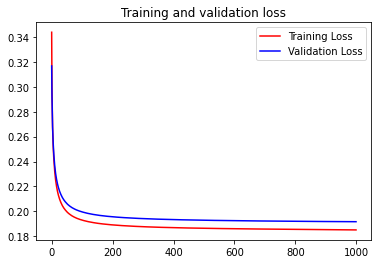

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


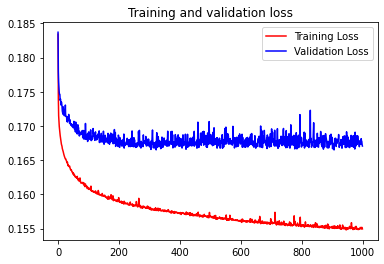

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


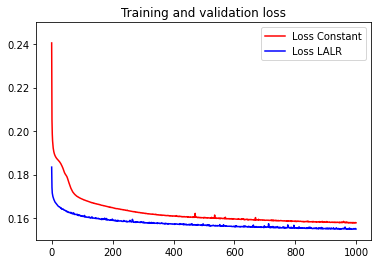

In [39]:
  %matplotlib inline
import matplotlib.pyplot as plt
loss_const = history_const.history['loss']
loss_lalr = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Training and validation loss')
plt.ylim(0.15,0.25)
plt.legend()
plt.savefig('quantile_5.png')
plt.show()


Batch size =128

In [58]:
q = 0.05
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_16=model.fit(x_train, y_train, epochs = 1000, batch_size = 16,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  353.3339
Epoch 0 LR = 0.047666260172866654
Epoch 1/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0713 - val_loss: 0.0714
The value of K_z is  247.95967
Epoch 1 LR = 0.06792276015628747
Epoch 2/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0718 - val_loss: 0.0717
The value of K_z is  276.57684
Epoch 2 LR = 0.060894849563455936
Epoch 3/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0713 - val_loss: 0.0708
The value of K_z is  291.8474
Epoch 3 LR = 0.05770859896076796
Epoch 4/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0707 - val_loss: 0.0703
The value of K_z is  340.1037
Epoch 4 LR = 0.04952050014753064
Epoch 5/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0709 - val_loss: 0.0699
The value of K_z is  310.0106
Epoch 5 LR = 0.05432751598876065
Epoch 6/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0713 - val_loss: 0

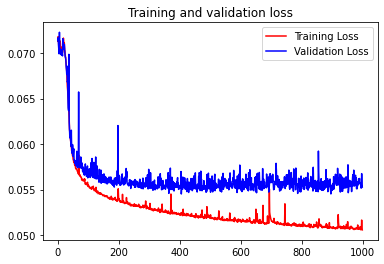

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history_16.history['loss']
val_loss = history_16.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [67]:
q = 0.05
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const_16=model.fit(x_train, y_train, epochs = 1000, batch_size = 16,validation_data=(x_test,y_test))

Epoch 1/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.1265 - val_loss: 0.0977
Epoch 2/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0923 - val_loss: 0.0887
Epoch 3/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0867 - val_loss: 0.0851
Epoch 4/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0841 - val_loss: 0.0831
Epoch 5/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0824 - val_loss: 0.0817
Epoch 6/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0813 - val_loss: 0.0808
Epoch 7/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0805 - val_loss: 0.0801
Epoch 8/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0799 - val_loss: 0.0795
Epoch 9/1000
1153/1153 [==============================] - 2s 2ms/step - loss: 0.0794 - val_loss: 0.0791
Epoch 10/1000
1153/1153 [==============================] - 2s 2m

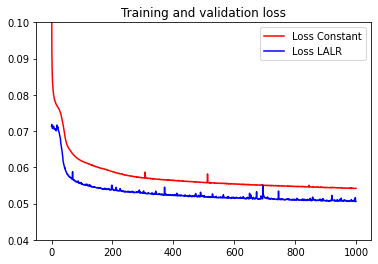

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
loss_const = history_const_16.history['loss']
loss_lalr = history_16.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Training and validation loss')
plt.ylim(0.04,0.1)
plt.legend()
plt.savefig('quantile_5.png')
plt.show()
